<h1>Notebook with refactored code for ResNet18 variants on CIFAR100</h1>
    
This notebook may be used for experiments on hierarchy training on small networks

<h3>Import modules and function definitions</h3>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.fx as fx
import torchvision
from torchvision.datasets import CIFAR100
from torchvision.transforms import ToTensor, Lambda
from torch.utils.data import Dataset, DataLoader, random_split
#from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt

import wordnet_graph as wg
from nltk.corpus import wordnet as wn
import networkx as nx

from CifarResNetGen import CifarResNet
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck

from torch_graph import BridgeGraph

from MyModules import MidOutBlock, EndStack
from MyLosses import MyCrossEntropyLoss, MyHDL, MyScatteredHL, ShallowAccuracyMeter, DeepAccuracyMeter
from MyTrain import train_net, print_results, plot_grad_flow
import fx_forward_hook as fxfh
#remember to use %matplotlib notebook with plot_grad_flow for interactivity

import psutil
import time
from copy import deepcopy
#import random

In [2]:
#checking CUDA availability
if torch.cuda.is_available():
    cuda_count=torch.cuda.device_count()
    print(cuda_count, "CUDA devices available")
    print("list of CUDA devices :")
    for i in range(cuda_count):
        print("- device", i, ":", torch.cuda.get_device_name(i))
    print("Current CUDA device :\n device", torch.cuda.current_device(), ":",torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("CUDA not available")
device=torch.device("cuda:{}".format(torch.cuda.current_device()) if torch.cuda.is_available() else "cpu")

1 CUDA devices available
list of CUDA devices :
- device 0 : NVIDIA GeForce RTX 2070
Current CUDA device :
 device 0 : NVIDIA GeForce RTX 2070


<h3>Defining dataset structure</h3>

In [3]:
#getting labels
dataset=CIFAR100(root='datasets/', download=True)
raw_labels=dataset.classes
print(raw_labels)

Files already downloaded and verified
['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle

In [4]:
#correcting values for wordnet
labels=deepcopy(raw_labels)
labels[1]="fish"
labels[47]="maple"

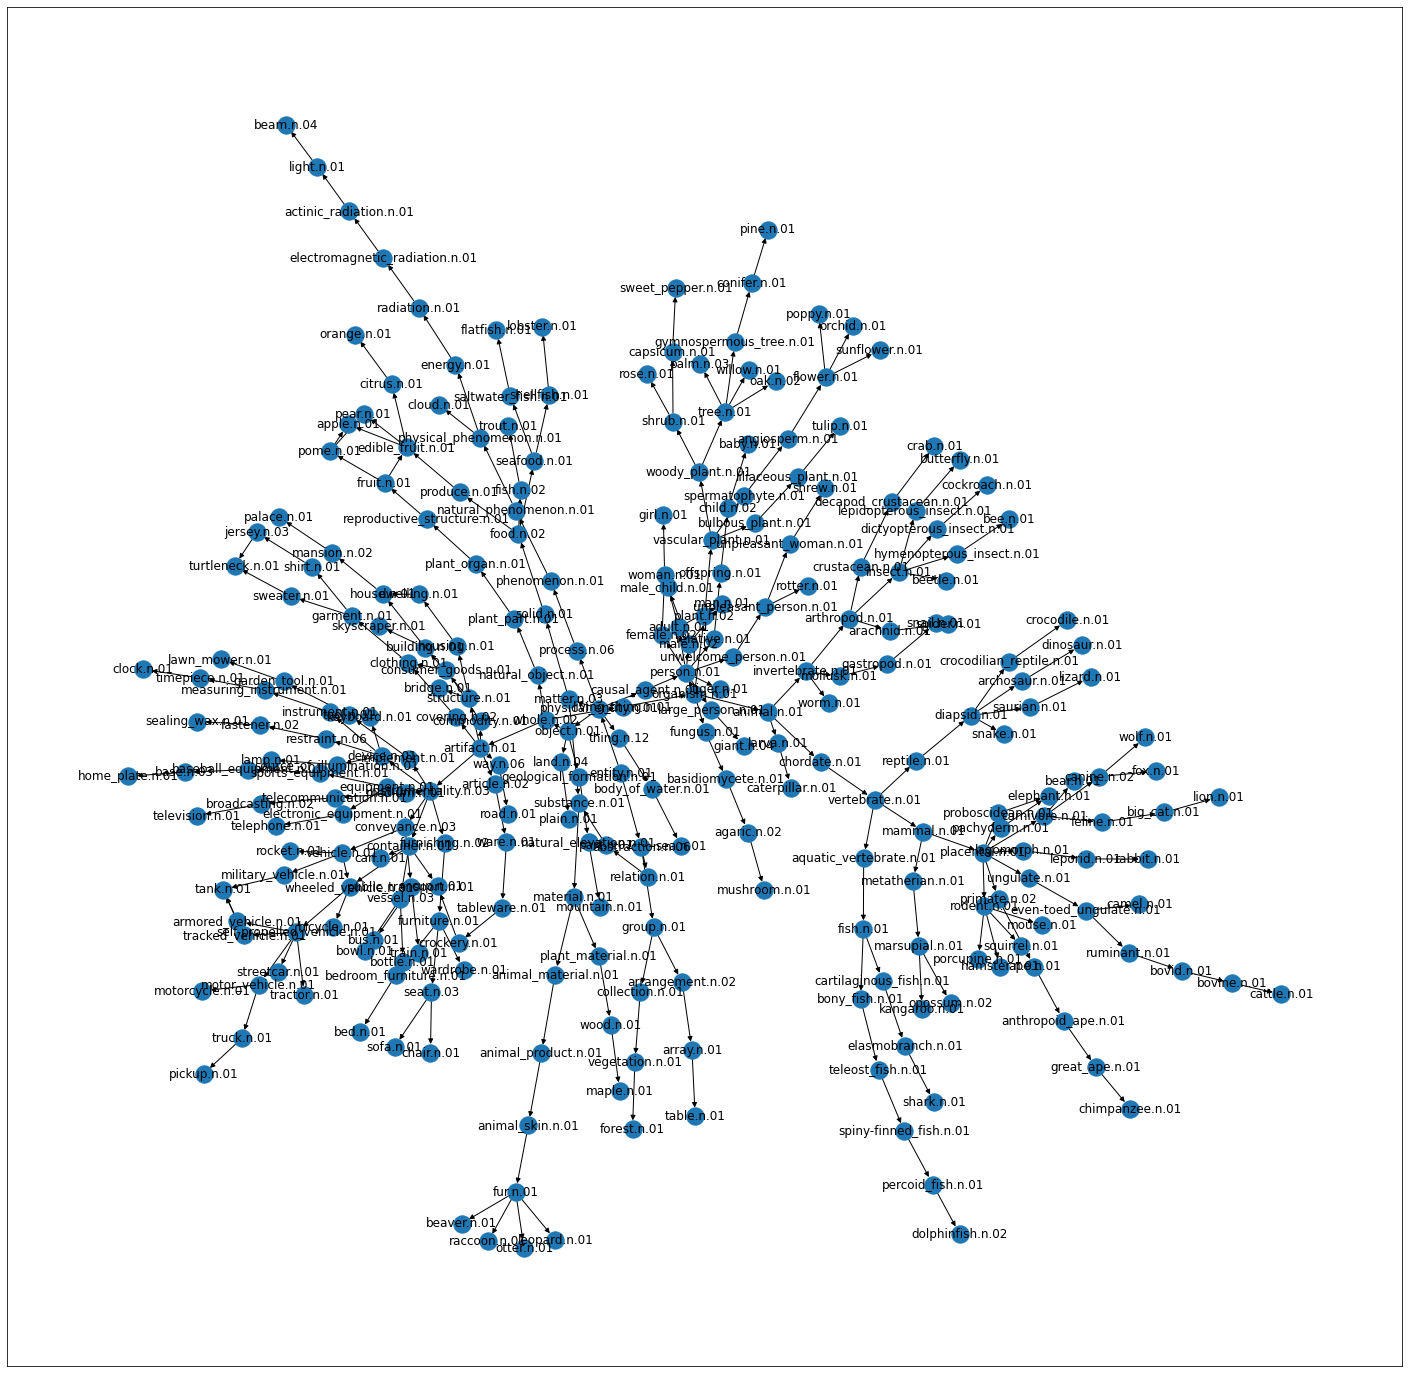

In [5]:
#Wordnet graph for CIFAR-100

graph=wg.words2graph(labels)
plt.figure(figsize=(25,25)) 
nx.draw_networkx(graph, pos=nx.nx_agraph.pygraphviz_layout(graph))
plt.show()

In [6]:
def get_higher_classes(labels):
    classes=[]
    for i in range(len(labels)):
        ss=wn.synsets(labels[i])[0]
        ss_root=ss.hypernym_paths()
        syn = [ss_root[0][s].lemma_names('eng')[0] for s in range(1, 4)]
        syn.append(labels[i])
        classes.append(syn[::-1])
    return classes

classes=get_higher_classes(labels)

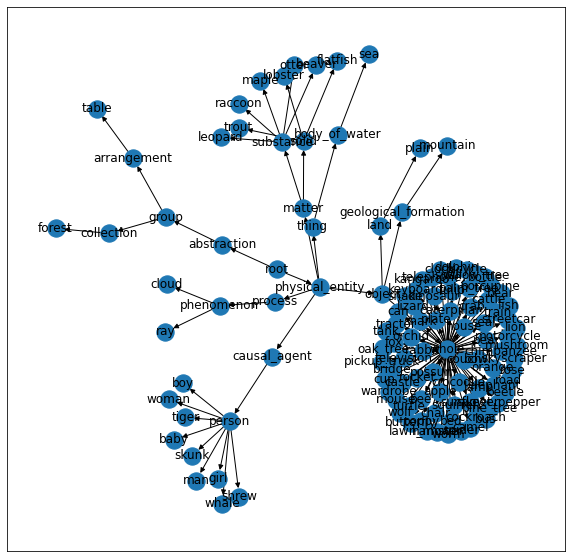

In [7]:
graph=nx.DiGraph()
graph.add_node("root")
for j in range(4)[::-1]:
    for i in range(len(classes)):
        if j==3:
            graph.add_node(classes[i][j])
            graph.add_edge("root",classes[i][j])
        else:
            graph.add_node(classes[i][j])
            graph.add_edge(classes[i][j+1],classes[i][j])
plt.figure(figsize=(10,10)) 
nx.draw_networkx(graph, pos=nx.nx_agraph.pygraphviz_layout(graph))
plt.show()

<h3>Importing dataset with decided hierarchy</h3>

In [8]:
#creating dictionnaries
L0,L1,L2,L3=zip(*classes)

sortedL1=sorted(set(L1))
sortedL2=sorted(set(L2))
sortedL3=sorted(set(L3))

dictL1={sortedL1[i]:i for i in range(len(sortedL1))}
dictL2={sortedL2[i]:i for i in range(len(sortedL2))}
dictL3={sortedL3[i]:i for i in range(len(sortedL3))}

labeldict={i:(i,dictL1[classes[i][1]],dictL2[classes[i][2]],dictL3[classes[i][3]]) for i in range(100)}

print(labeldict)

{0: (0, 9, 3, 1), 1: (1, 9, 3, 1), 2: (2, 5, 0, 1), 3: (3, 9, 3, 1), 4: (4, 8, 2, 1), 5: (5, 9, 3, 1), 6: (6, 9, 3, 1), 7: (7, 9, 3, 1), 8: (8, 9, 3, 1), 9: (9, 9, 3, 1), 10: (10, 9, 3, 1), 11: (11, 5, 0, 1), 12: (12, 9, 3, 1), 13: (13, 9, 3, 1), 14: (14, 9, 3, 1), 15: (15, 9, 3, 1), 16: (16, 9, 3, 1), 17: (17, 9, 3, 1), 18: (18, 9, 3, 1), 19: (19, 9, 3, 1), 20: (20, 9, 3, 1), 21: (21, 9, 3, 1), 22: (22, 9, 3, 1), 23: (23, 6, 4, 1), 24: (24, 9, 3, 1), 25: (25, 9, 3, 1), 26: (26, 9, 3, 1), 27: (27, 9, 3, 1), 28: (28, 9, 3, 1), 29: (29, 9, 3, 1), 30: (30, 9, 3, 1), 31: (31, 9, 3, 1), 32: (32, 7, 2, 1), 33: (33, 2, 1, 0), 34: (34, 9, 3, 1), 35: (35, 5, 0, 1), 36: (36, 9, 3, 1), 37: (37, 9, 3, 1), 38: (38, 9, 3, 1), 39: (39, 9, 3, 1), 40: (40, 9, 3, 1), 41: (41, 9, 3, 1), 42: (42, 8, 2, 1), 43: (43, 9, 3, 1), 44: (44, 9, 3, 1), 45: (45, 7, 2, 1), 46: (46, 5, 0, 1), 47: (47, 8, 2, 1), 48: (48, 9, 3, 1), 49: (49, 3, 3, 1), 50: (50, 9, 3, 1), 51: (51, 9, 3, 1), 52: (52, 9, 3, 1), 53: (53, 9, 

In [9]:
#creating hierarchy function
def hierarchy_fun_cifar100(x,dictarg):
    return dictarg[x]

#importing dataset
dataset=CIFAR100(root='datasets/', download=True, transform=ToTensor(),
                target_transform=Lambda(lambda y : torch.LongTensor(hierarchy_fun_cifar100(y,labeldict))))
testset=CIFAR100(root='datasets/', train=False, transform=ToTensor(),
                target_transform=Lambda(lambda y : torch.LongTensor(hierarchy_fun_cifar100(y,labeldict))))

#splitting, 90% train, 10% validation
#setting manual seed to be able to reproduce results
torch.manual_seed(123456789)
valset_size=int(0.1*len(dataset))
trainset, valset=random_split(dataset, [len(dataset)-valset_size, valset_size])

#checking valset class repartition
valset_classcount = np.zeros(100)
for _,labels in valset:
    valset_classcount[int(labels[0])]+=1
for c in range(len(valset_classcount)) :
    print(f"Number of images in class {c} are {valset_classcount[c]}")

#counting available cores
num_cores=len(psutil.Process().cpu_affinity())

#creating the dataloaders
batchsize=128
trainloader=DataLoader(trainset, batchsize, shuffle=True)#, num_workers=num_cores, pin_memory=True)
valloader=DataLoader(valset, batchsize)#, num_workers=num_cores, pin_memory=True)
testloader=DataLoader(testset, batchsize)#, num_workers=num_cores, pin_memory=True)

#hierarchy size
hierarchy_size=[100,12,6,2]

Files already downloaded and verified
Number of images in class 0 are 50.0
Number of images in class 1 are 61.0
Number of images in class 2 are 50.0
Number of images in class 3 are 53.0
Number of images in class 4 are 50.0
Number of images in class 5 are 56.0
Number of images in class 6 are 57.0
Number of images in class 7 are 54.0
Number of images in class 8 are 48.0
Number of images in class 9 are 41.0
Number of images in class 10 are 53.0
Number of images in class 11 are 62.0
Number of images in class 12 are 54.0
Number of images in class 13 are 54.0
Number of images in class 14 are 53.0
Number of images in class 15 are 49.0
Number of images in class 16 are 41.0
Number of images in class 17 are 62.0
Number of images in class 18 are 57.0
Number of images in class 19 are 59.0
Number of images in class 20 are 56.0
Number of images in class 21 are 56.0
Number of images in class 22 are 38.0
Number of images in class 23 are 53.0
Number of images in class 24 are 49.0
Number of images in cl

<h3>Example of forward hook usage</h3>

In [10]:
def MyCode(self, output, string, is_model_output):
    if is_model_output:
        print("output", string, self.batch_id)
    else:
        print("inside", string, self.batch_id)

In [11]:
fxfh.hook_register(MyCode)

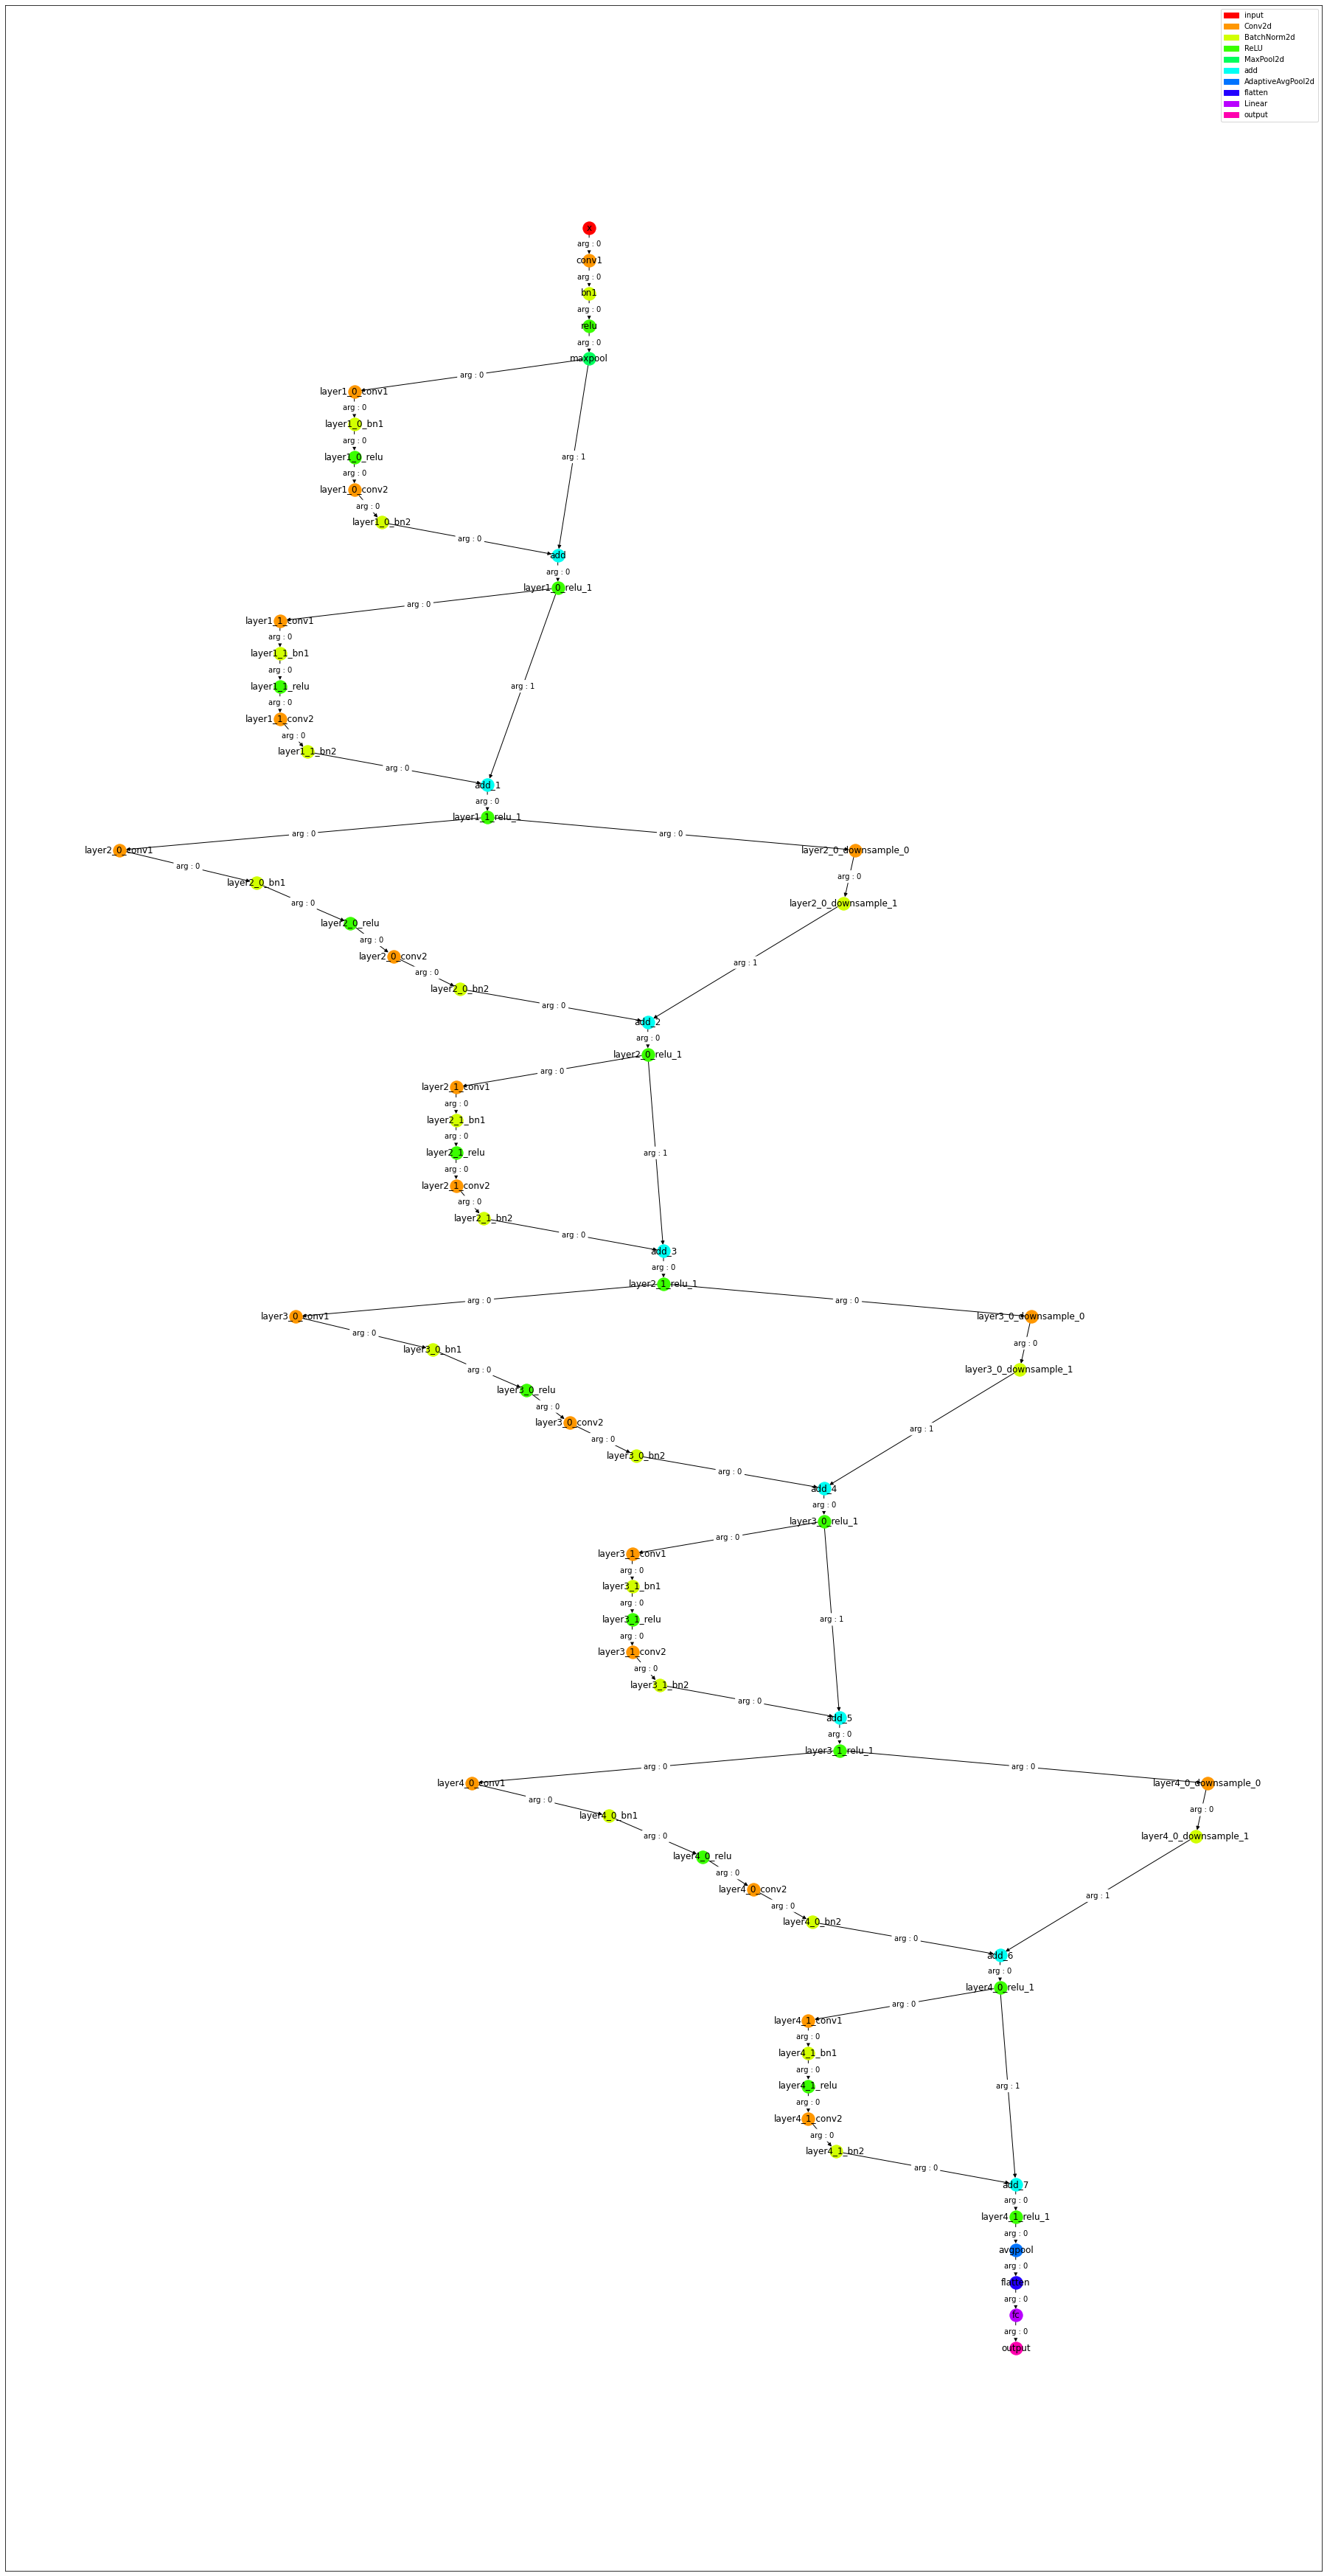

In [12]:
#defining net
middleloss_bridge=BridgeGraph(ResNet(BasicBlock, [2, 2, 2, 2], num_classes=100))
middleloss_bridge.plot(32,64)

In [13]:
middleloss_bridge.add_submodule("midoutblock1",MidOutBlock(200,2))
with middleloss_bridge.inserting_after(middleloss_bridge.get_fx_node("layer1_1_relu_1")):
    new_node1=middleloss_bridge.add_node("midoutblock", "call_module", "midoutblock1", args=(middleloss_bridge.get_fx_node("layer1_1_relu_1"),),kwargs={})

middleloss_bridge.add_submodule("midoutblock2",MidOutBlock(300,6))
with middleloss_bridge.inserting_after(middleloss_bridge.get_fx_node("layer2_1_relu_1")):
    new_node2=middleloss_bridge.add_node("midoutblock", "call_module", "midoutblock2", args=(middleloss_bridge.get_fx_node("layer2_1_relu_1"),),kwargs={})

middleloss_bridge.add_submodule("midoutblock3",MidOutBlock(400,12))
with middleloss_bridge.inserting_after(middleloss_bridge.get_fx_node("layer3_1_relu_1")):
    new_node3=middleloss_bridge.add_node("midoutblock", "call_module", "midoutblock3", args=(middleloss_bridge.get_fx_node("layer3_1_relu_1"),),kwargs={})

middleloss_bridge.add_deep_edge((middleloss_bridge.get_fx_node("fc"),
                                middleloss_bridge.get_fx_node(new_node3),
                                middleloss_bridge.get_fx_node(new_node2),
                                middleloss_bridge.get_fx_node(new_node1)),"output")
_=middleloss_bridge.recompile()

In [14]:
print(middleloss_bridge.fx)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Module(
    (0): Module(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Module(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2):

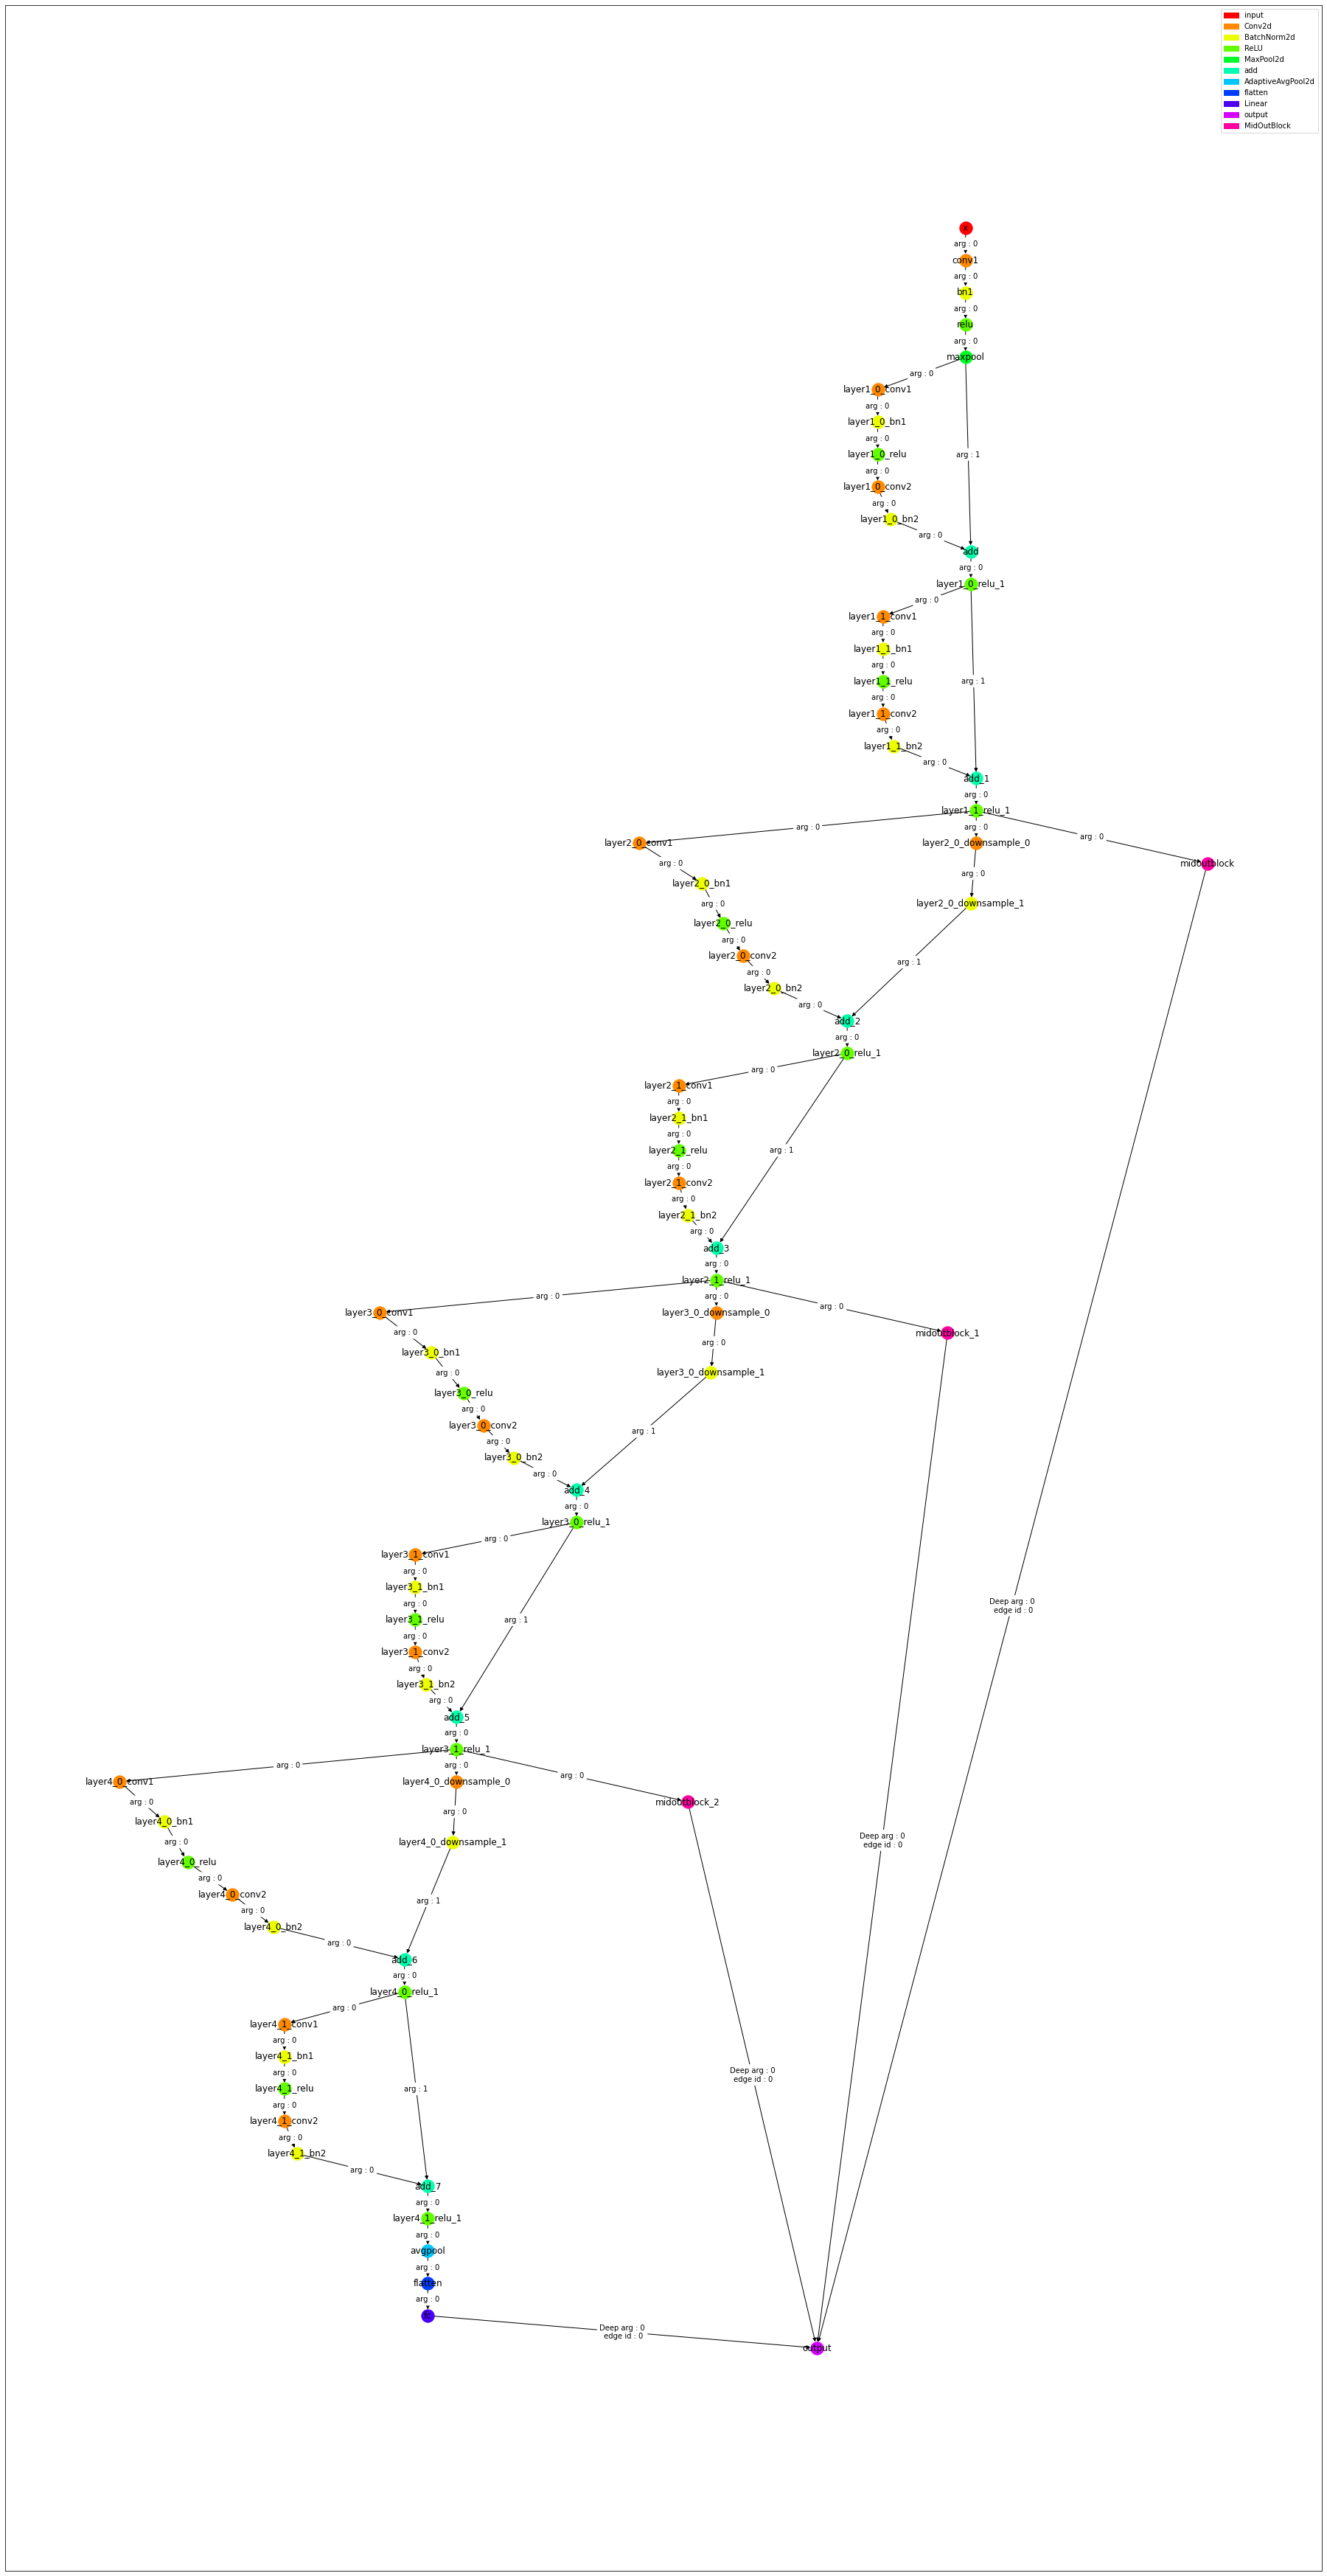

In [15]:
middleloss_bridge.plot(32,64)

In [16]:
#initialising midoutblocks before retracing
with torch.no_grad():
    _=middleloss_bridge.fx(torch.zeros([128,3,32,32]))

In [17]:
middleloss_bridge.retrace()
print(middleloss_bridge.fx)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Module(
    (0): Module(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Module(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2):

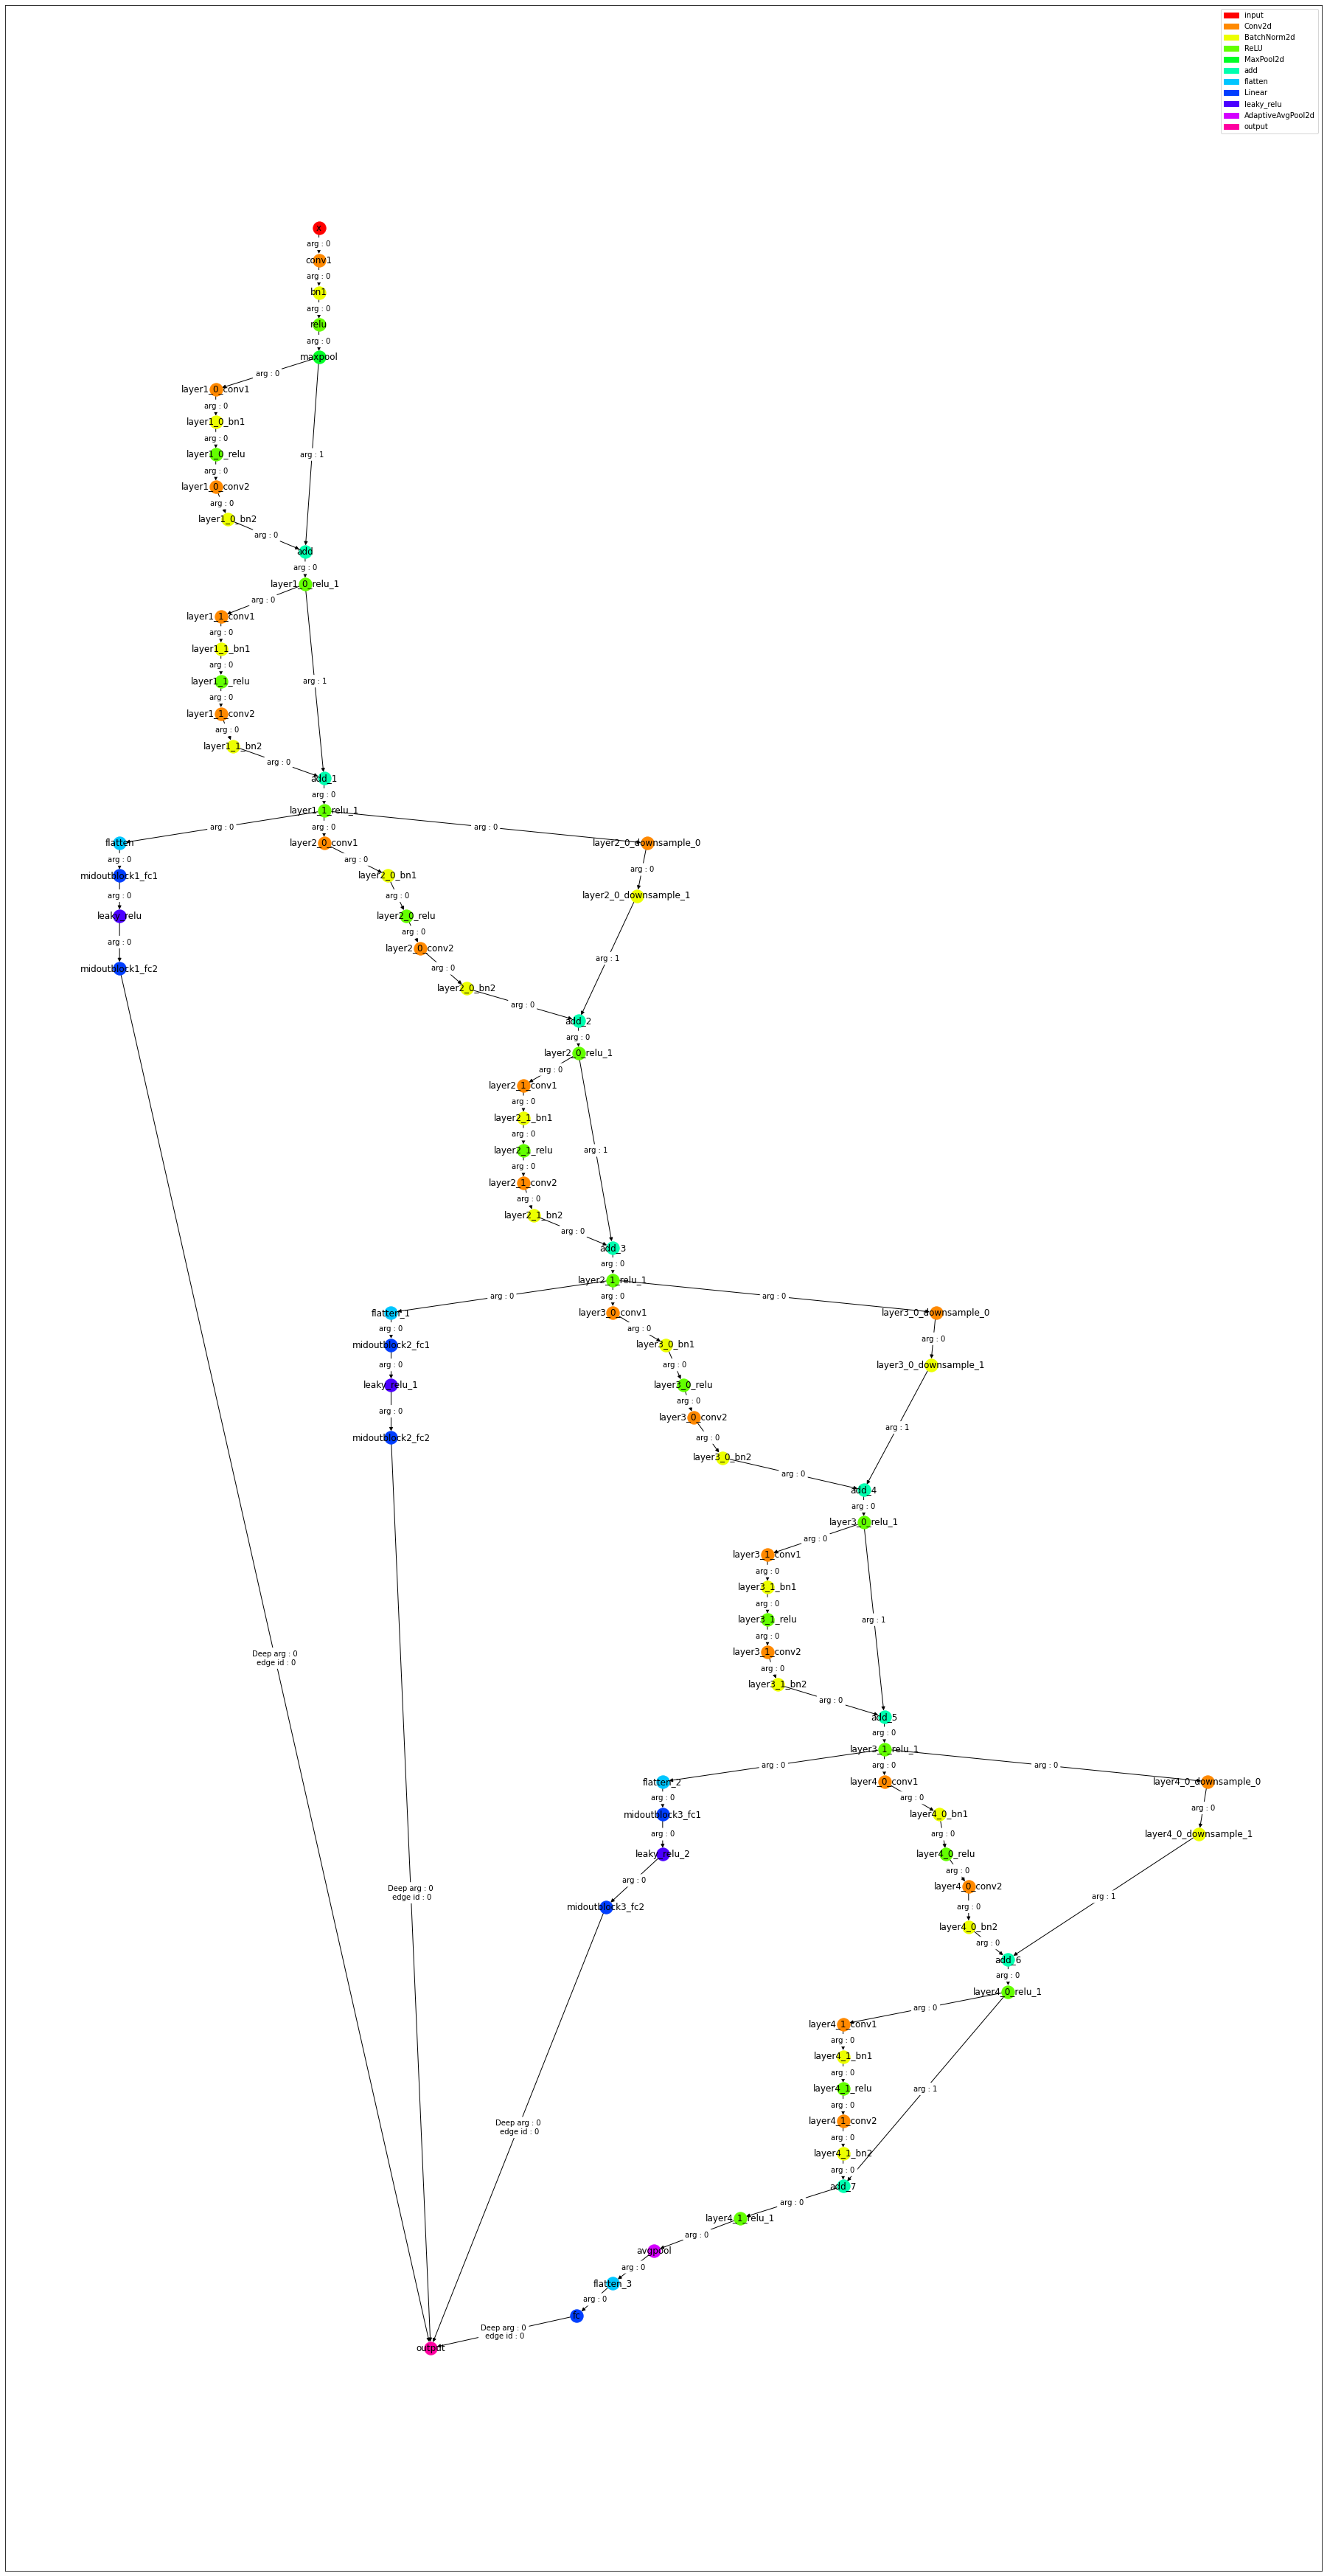

In [18]:
middleloss_bridge.plot(32,64)

In [19]:
fxfh.save_results(middleloss_bridge.fx, trainloader, device)

inside conv1 0
inside bn1 0
inside relu 0
inside maxpool 0
inside layer1_0_conv1 0
inside layer1_0_bn1 0
inside layer1_0_relu 0
inside layer1_0_conv2 0
inside layer1_0_bn2 0
inside add 0
inside layer1_0_relu_1 0
inside layer1_1_conv1 0
inside layer1_1_bn1 0
inside layer1_1_relu 0
inside layer1_1_conv2 0
inside layer1_1_bn2 0
inside add_1 0
inside layer1_1_relu_1 0
inside flatten 0
inside midoutblock1_fc1 0
inside leaky_relu 0
output midoutblock1_fc2 0
inside layer2_0_conv1 0
inside layer2_0_bn1 0
inside layer2_0_relu 0
inside layer2_0_conv2 0
inside layer2_0_bn2 0
inside layer2_0_downsample_0 0
inside layer2_0_downsample_1 0
inside add_2 0
inside layer2_0_relu_1 0
inside layer2_1_conv1 0
inside layer2_1_bn1 0
inside layer2_1_relu 0
inside layer2_1_conv2 0
inside layer2_1_bn2 0
inside add_3 0
inside layer2_1_relu_1 0
inside flatten_1 0
inside midoutblock2_fc1 0
inside leaky_relu_1 0
output midoutblock2_fc2 0
inside layer3_0_conv1 0
inside layer3_0_bn1 0
inside layer3_0_relu 0
inside lay

inside bn1 5
inside relu 5
inside maxpool 5
inside layer1_0_conv1 5
inside layer1_0_bn1 5
inside layer1_0_relu 5
inside layer1_0_conv2 5
inside layer1_0_bn2 5
inside add 5
inside layer1_0_relu_1 5
inside layer1_1_conv1 5
inside layer1_1_bn1 5
inside layer1_1_relu 5
inside layer1_1_conv2 5
inside layer1_1_bn2 5
inside add_1 5
inside layer1_1_relu_1 5
inside flatten 5
inside midoutblock1_fc1 5
inside leaky_relu 5
output midoutblock1_fc2 5
inside layer2_0_conv1 5
inside layer2_0_bn1 5
inside layer2_0_relu 5
inside layer2_0_conv2 5
inside layer2_0_bn2 5
inside layer2_0_downsample_0 5
inside layer2_0_downsample_1 5
inside add_2 5
inside layer2_0_relu_1 5
inside layer2_1_conv1 5
inside layer2_1_bn1 5
inside layer2_1_relu 5
inside layer2_1_conv2 5
inside layer2_1_bn2 5
inside add_3 5
inside layer2_1_relu_1 5
inside flatten_1 5
inside midoutblock2_fc1 5
inside leaky_relu_1 5
output midoutblock2_fc2 5
inside layer3_0_conv1 5
inside layer3_0_bn1 5
inside layer3_0_relu 5
inside layer3_0_conv2 5
i

inside conv1 10
inside bn1 10
inside relu 10
inside maxpool 10
inside layer1_0_conv1 10
inside layer1_0_bn1 10
inside layer1_0_relu 10
inside layer1_0_conv2 10
inside layer1_0_bn2 10
inside add 10
inside layer1_0_relu_1 10
inside layer1_1_conv1 10
inside layer1_1_bn1 10
inside layer1_1_relu 10
inside layer1_1_conv2 10
inside layer1_1_bn2 10
inside add_1 10
inside layer1_1_relu_1 10
inside flatten 10
inside midoutblock1_fc1 10
inside leaky_relu 10
output midoutblock1_fc2 10
inside layer2_0_conv1 10
inside layer2_0_bn1 10
inside layer2_0_relu 10
inside layer2_0_conv2 10
inside layer2_0_bn2 10
inside layer2_0_downsample_0 10
inside layer2_0_downsample_1 10
inside add_2 10
inside layer2_0_relu_1 10
inside layer2_1_conv1 10
inside layer2_1_bn1 10
inside layer2_1_relu 10
inside layer2_1_conv2 10
inside layer2_1_bn2 10
inside add_3 10
inside layer2_1_relu_1 10
inside flatten_1 10
inside midoutblock2_fc1 10
inside leaky_relu_1 10
output midoutblock2_fc2 10
inside layer3_0_conv1 10
inside layer

inside conv1 15
inside bn1 15
inside relu 15
inside maxpool 15
inside layer1_0_conv1 15
inside layer1_0_bn1 15
inside layer1_0_relu 15
inside layer1_0_conv2 15
inside layer1_0_bn2 15
inside add 15
inside layer1_0_relu_1 15
inside layer1_1_conv1 15
inside layer1_1_bn1 15
inside layer1_1_relu 15
inside layer1_1_conv2 15
inside layer1_1_bn2 15
inside add_1 15
inside layer1_1_relu_1 15
inside flatten 15
inside midoutblock1_fc1 15
inside leaky_relu 15
output midoutblock1_fc2 15
inside layer2_0_conv1 15
inside layer2_0_bn1 15
inside layer2_0_relu 15
inside layer2_0_conv2 15
inside layer2_0_bn2 15
inside layer2_0_downsample_0 15
inside layer2_0_downsample_1 15
inside add_2 15
inside layer2_0_relu_1 15
inside layer2_1_conv1 15
inside layer2_1_bn1 15
inside layer2_1_relu 15
inside layer2_1_conv2 15
inside layer2_1_bn2 15
inside add_3 15
inside layer2_1_relu_1 15
inside flatten_1 15
inside midoutblock2_fc1 15
inside leaky_relu_1 15
output midoutblock2_fc2 15
inside layer3_0_conv1 15
inside layer

inside conv1 20
inside bn1 20
inside relu 20
inside maxpool 20
inside layer1_0_conv1 20
inside layer1_0_bn1 20
inside layer1_0_relu 20
inside layer1_0_conv2 20
inside layer1_0_bn2 20
inside add 20
inside layer1_0_relu_1 20
inside layer1_1_conv1 20
inside layer1_1_bn1 20
inside layer1_1_relu 20
inside layer1_1_conv2 20
inside layer1_1_bn2 20
inside add_1 20
inside layer1_1_relu_1 20
inside flatten 20
inside midoutblock1_fc1 20
inside leaky_relu 20
output midoutblock1_fc2 20
inside layer2_0_conv1 20
inside layer2_0_bn1 20
inside layer2_0_relu 20
inside layer2_0_conv2 20
inside layer2_0_bn2 20
inside layer2_0_downsample_0 20
inside layer2_0_downsample_1 20
inside add_2 20
inside layer2_0_relu_1 20
inside layer2_1_conv1 20
inside layer2_1_bn1 20
inside layer2_1_relu 20
inside layer2_1_conv2 20
inside layer2_1_bn2 20
inside add_3 20
inside layer2_1_relu_1 20
inside flatten_1 20
inside midoutblock2_fc1 20
inside leaky_relu_1 20
output midoutblock2_fc2 20
inside layer3_0_conv1 20
inside layer

inside bn1 25
inside relu 25
inside maxpool 25
inside layer1_0_conv1 25
inside layer1_0_bn1 25
inside layer1_0_relu 25
inside layer1_0_conv2 25
inside layer1_0_bn2 25
inside add 25
inside layer1_0_relu_1 25
inside layer1_1_conv1 25
inside layer1_1_bn1 25
inside layer1_1_relu 25
inside layer1_1_conv2 25
inside layer1_1_bn2 25
inside add_1 25
inside layer1_1_relu_1 25
inside flatten 25
inside midoutblock1_fc1 25
inside leaky_relu 25
output midoutblock1_fc2 25
inside layer2_0_conv1 25
inside layer2_0_bn1 25
inside layer2_0_relu 25
inside layer2_0_conv2 25
inside layer2_0_bn2 25
inside layer2_0_downsample_0 25
inside layer2_0_downsample_1 25
inside add_2 25
inside layer2_0_relu_1 25
inside layer2_1_conv1 25
inside layer2_1_bn1 25
inside layer2_1_relu 25
inside layer2_1_conv2 25
inside layer2_1_bn2 25
inside add_3 25
inside layer2_1_relu_1 25
inside flatten_1 25
inside midoutblock2_fc1 25
inside leaky_relu_1 25
output midoutblock2_fc2 25
inside layer3_0_conv1 25
inside layer3_0_bn1 25
insid

inside conv1 30
inside bn1 30
inside relu 30
inside maxpool 30
inside layer1_0_conv1 30
inside layer1_0_bn1 30
inside layer1_0_relu 30
inside layer1_0_conv2 30
inside layer1_0_bn2 30
inside add 30
inside layer1_0_relu_1 30
inside layer1_1_conv1 30
inside layer1_1_bn1 30
inside layer1_1_relu 30
inside layer1_1_conv2 30
inside layer1_1_bn2 30
inside add_1 30
inside layer1_1_relu_1 30
inside flatten 30
inside midoutblock1_fc1 30
inside leaky_relu 30
output midoutblock1_fc2 30
inside layer2_0_conv1 30
inside layer2_0_bn1 30
inside layer2_0_relu 30
inside layer2_0_conv2 30
inside layer2_0_bn2 30
inside layer2_0_downsample_0 30
inside layer2_0_downsample_1 30
inside add_2 30
inside layer2_0_relu_1 30
inside layer2_1_conv1 30
inside layer2_1_bn1 30
inside layer2_1_relu 30
inside layer2_1_conv2 30
inside layer2_1_bn2 30
inside add_3 30
inside layer2_1_relu_1 30
inside flatten_1 30
inside midoutblock2_fc1 30
inside leaky_relu_1 30
output midoutblock2_fc2 30
inside layer3_0_conv1 30
inside layer

inside bn1 35
inside relu 35
inside maxpool 35
inside layer1_0_conv1 35
inside layer1_0_bn1 35
inside layer1_0_relu 35
inside layer1_0_conv2 35
inside layer1_0_bn2 35
inside add 35
inside layer1_0_relu_1 35
inside layer1_1_conv1 35
inside layer1_1_bn1 35
inside layer1_1_relu 35
inside layer1_1_conv2 35
inside layer1_1_bn2 35
inside add_1 35
inside layer1_1_relu_1 35
inside flatten 35
inside midoutblock1_fc1 35
inside leaky_relu 35
output midoutblock1_fc2 35
inside layer2_0_conv1 35
inside layer2_0_bn1 35
inside layer2_0_relu 35
inside layer2_0_conv2 35
inside layer2_0_bn2 35
inside layer2_0_downsample_0 35
inside layer2_0_downsample_1 35
inside add_2 35
inside layer2_0_relu_1 35
inside layer2_1_conv1 35
inside layer2_1_bn1 35
inside layer2_1_relu 35
inside layer2_1_conv2 35
inside layer2_1_bn2 35
inside add_3 35
inside layer2_1_relu_1 35
inside flatten_1 35
inside midoutblock2_fc1 35
inside leaky_relu_1 35
output midoutblock2_fc2 35
inside layer3_0_conv1 35
inside layer3_0_bn1 35
insid

inside bn1 40
inside relu 40
inside maxpool 40
inside layer1_0_conv1 40
inside layer1_0_bn1 40
inside layer1_0_relu 40
inside layer1_0_conv2 40
inside layer1_0_bn2 40
inside add 40
inside layer1_0_relu_1 40
inside layer1_1_conv1 40
inside layer1_1_bn1 40
inside layer1_1_relu 40
inside layer1_1_conv2 40
inside layer1_1_bn2 40
inside add_1 40
inside layer1_1_relu_1 40
inside flatten 40
inside midoutblock1_fc1 40
inside leaky_relu 40
output midoutblock1_fc2 40
inside layer2_0_conv1 40
inside layer2_0_bn1 40
inside layer2_0_relu 40
inside layer2_0_conv2 40
inside layer2_0_bn2 40
inside layer2_0_downsample_0 40
inside layer2_0_downsample_1 40
inside add_2 40
inside layer2_0_relu_1 40
inside layer2_1_conv1 40
inside layer2_1_bn1 40
inside layer2_1_relu 40
inside layer2_1_conv2 40
inside layer2_1_bn2 40
inside add_3 40
inside layer2_1_relu_1 40
inside flatten_1 40
inside midoutblock2_fc1 40
inside leaky_relu_1 40
output midoutblock2_fc2 40
inside layer3_0_conv1 40
inside layer3_0_bn1 40
insid

inside bn1 45
inside relu 45
inside maxpool 45
inside layer1_0_conv1 45
inside layer1_0_bn1 45
inside layer1_0_relu 45
inside layer1_0_conv2 45
inside layer1_0_bn2 45
inside add 45
inside layer1_0_relu_1 45
inside layer1_1_conv1 45
inside layer1_1_bn1 45
inside layer1_1_relu 45
inside layer1_1_conv2 45
inside layer1_1_bn2 45
inside add_1 45
inside layer1_1_relu_1 45
inside flatten 45
inside midoutblock1_fc1 45
inside leaky_relu 45
output midoutblock1_fc2 45
inside layer2_0_conv1 45
inside layer2_0_bn1 45
inside layer2_0_relu 45
inside layer2_0_conv2 45
inside layer2_0_bn2 45
inside layer2_0_downsample_0 45
inside layer2_0_downsample_1 45
inside add_2 45
inside layer2_0_relu_1 45
inside layer2_1_conv1 45
inside layer2_1_bn1 45
inside layer2_1_relu 45
inside layer2_1_conv2 45
inside layer2_1_bn2 45
inside add_3 45
inside layer2_1_relu_1 45
inside flatten_1 45
inside midoutblock2_fc1 45
inside leaky_relu_1 45
output midoutblock2_fc2 45
inside layer3_0_conv1 45
inside layer3_0_bn1 45
insid

inside conv1 50
inside bn1 50
inside relu 50
inside maxpool 50
inside layer1_0_conv1 50
inside layer1_0_bn1 50
inside layer1_0_relu 50
inside layer1_0_conv2 50
inside layer1_0_bn2 50
inside add 50
inside layer1_0_relu_1 50
inside layer1_1_conv1 50
inside layer1_1_bn1 50
inside layer1_1_relu 50
inside layer1_1_conv2 50
inside layer1_1_bn2 50
inside add_1 50
inside layer1_1_relu_1 50
inside flatten 50
inside midoutblock1_fc1 50
inside leaky_relu 50
output midoutblock1_fc2 50
inside layer2_0_conv1 50
inside layer2_0_bn1 50
inside layer2_0_relu 50
inside layer2_0_conv2 50
inside layer2_0_bn2 50
inside layer2_0_downsample_0 50
inside layer2_0_downsample_1 50
inside add_2 50
inside layer2_0_relu_1 50
inside layer2_1_conv1 50
inside layer2_1_bn1 50
inside layer2_1_relu 50
inside layer2_1_conv2 50
inside layer2_1_bn2 50
inside add_3 50
inside layer2_1_relu_1 50
inside flatten_1 50
inside midoutblock2_fc1 50
inside leaky_relu_1 50
output midoutblock2_fc2 50
inside layer3_0_conv1 50
inside layer

inside conv1 55
inside bn1 55
inside relu 55
inside maxpool 55
inside layer1_0_conv1 55
inside layer1_0_bn1 55
inside layer1_0_relu 55
inside layer1_0_conv2 55
inside layer1_0_bn2 55
inside add 55
inside layer1_0_relu_1 55
inside layer1_1_conv1 55
inside layer1_1_bn1 55
inside layer1_1_relu 55
inside layer1_1_conv2 55
inside layer1_1_bn2 55
inside add_1 55
inside layer1_1_relu_1 55
inside flatten 55
inside midoutblock1_fc1 55
inside leaky_relu 55
output midoutblock1_fc2 55
inside layer2_0_conv1 55
inside layer2_0_bn1 55
inside layer2_0_relu 55
inside layer2_0_conv2 55
inside layer2_0_bn2 55
inside layer2_0_downsample_0 55
inside layer2_0_downsample_1 55
inside add_2 55
inside layer2_0_relu_1 55
inside layer2_1_conv1 55
inside layer2_1_bn1 55
inside layer2_1_relu 55
inside layer2_1_conv2 55
inside layer2_1_bn2 55
inside add_3 55
inside layer2_1_relu_1 55
inside flatten_1 55
inside midoutblock2_fc1 55
inside leaky_relu_1 55
output midoutblock2_fc2 55
inside layer3_0_conv1 55
inside layer

inside conv1 60
inside bn1 60
inside relu 60
inside maxpool 60
inside layer1_0_conv1 60
inside layer1_0_bn1 60
inside layer1_0_relu 60
inside layer1_0_conv2 60
inside layer1_0_bn2 60
inside add 60
inside layer1_0_relu_1 60
inside layer1_1_conv1 60
inside layer1_1_bn1 60
inside layer1_1_relu 60
inside layer1_1_conv2 60
inside layer1_1_bn2 60
inside add_1 60
inside layer1_1_relu_1 60
inside flatten 60
inside midoutblock1_fc1 60
inside leaky_relu 60
output midoutblock1_fc2 60
inside layer2_0_conv1 60
inside layer2_0_bn1 60
inside layer2_0_relu 60
inside layer2_0_conv2 60
inside layer2_0_bn2 60
inside layer2_0_downsample_0 60
inside layer2_0_downsample_1 60
inside add_2 60
inside layer2_0_relu_1 60
inside layer2_1_conv1 60
inside layer2_1_bn1 60
inside layer2_1_relu 60
inside layer2_1_conv2 60
inside layer2_1_bn2 60
inside add_3 60
inside layer2_1_relu_1 60
inside flatten_1 60
inside midoutblock2_fc1 60
inside leaky_relu_1 60
output midoutblock2_fc2 60
inside layer3_0_conv1 60
inside layer

inside conv1 65
inside bn1 65
inside relu 65
inside maxpool 65
inside layer1_0_conv1 65
inside layer1_0_bn1 65
inside layer1_0_relu 65
inside layer1_0_conv2 65
inside layer1_0_bn2 65
inside add 65
inside layer1_0_relu_1 65
inside layer1_1_conv1 65
inside layer1_1_bn1 65
inside layer1_1_relu 65
inside layer1_1_conv2 65
inside layer1_1_bn2 65
inside add_1 65
inside layer1_1_relu_1 65
inside flatten 65
inside midoutblock1_fc1 65
inside leaky_relu 65
output midoutblock1_fc2 65
inside layer2_0_conv1 65
inside layer2_0_bn1 65
inside layer2_0_relu 65
inside layer2_0_conv2 65
inside layer2_0_bn2 65
inside layer2_0_downsample_0 65
inside layer2_0_downsample_1 65
inside add_2 65
inside layer2_0_relu_1 65
inside layer2_1_conv1 65
inside layer2_1_bn1 65
inside layer2_1_relu 65
inside layer2_1_conv2 65
inside layer2_1_bn2 65
inside add_3 65
inside layer2_1_relu_1 65
inside flatten_1 65
inside midoutblock2_fc1 65
inside leaky_relu_1 65
output midoutblock2_fc2 65
inside layer3_0_conv1 65
inside layer

inside conv1 70
inside bn1 70
inside relu 70
inside maxpool 70
inside layer1_0_conv1 70
inside layer1_0_bn1 70
inside layer1_0_relu 70
inside layer1_0_conv2 70
inside layer1_0_bn2 70
inside add 70
inside layer1_0_relu_1 70
inside layer1_1_conv1 70
inside layer1_1_bn1 70
inside layer1_1_relu 70
inside layer1_1_conv2 70
inside layer1_1_bn2 70
inside add_1 70
inside layer1_1_relu_1 70
inside flatten 70
inside midoutblock1_fc1 70
inside leaky_relu 70
output midoutblock1_fc2 70
inside layer2_0_conv1 70
inside layer2_0_bn1 70
inside layer2_0_relu 70
inside layer2_0_conv2 70
inside layer2_0_bn2 70
inside layer2_0_downsample_0 70
inside layer2_0_downsample_1 70
inside add_2 70
inside layer2_0_relu_1 70
inside layer2_1_conv1 70
inside layer2_1_bn1 70
inside layer2_1_relu 70
inside layer2_1_conv2 70
inside layer2_1_bn2 70
inside add_3 70
inside layer2_1_relu_1 70
inside flatten_1 70
inside midoutblock2_fc1 70
inside leaky_relu_1 70
output midoutblock2_fc2 70
inside layer3_0_conv1 70
inside layer

inside conv1 75
inside bn1 75
inside relu 75
inside maxpool 75
inside layer1_0_conv1 75
inside layer1_0_bn1 75
inside layer1_0_relu 75
inside layer1_0_conv2 75
inside layer1_0_bn2 75
inside add 75
inside layer1_0_relu_1 75
inside layer1_1_conv1 75
inside layer1_1_bn1 75
inside layer1_1_relu 75
inside layer1_1_conv2 75
inside layer1_1_bn2 75
inside add_1 75
inside layer1_1_relu_1 75
inside flatten 75
inside midoutblock1_fc1 75
inside leaky_relu 75
output midoutblock1_fc2 75
inside layer2_0_conv1 75
inside layer2_0_bn1 75
inside layer2_0_relu 75
inside layer2_0_conv2 75
inside layer2_0_bn2 75
inside layer2_0_downsample_0 75
inside layer2_0_downsample_1 75
inside add_2 75
inside layer2_0_relu_1 75
inside layer2_1_conv1 75
inside layer2_1_bn1 75
inside layer2_1_relu 75
inside layer2_1_conv2 75
inside layer2_1_bn2 75
inside add_3 75
inside layer2_1_relu_1 75
inside flatten_1 75
inside midoutblock2_fc1 75
inside leaky_relu_1 75
output midoutblock2_fc2 75
inside layer3_0_conv1 75
inside layer

inside conv1 80
inside bn1 80
inside relu 80
inside maxpool 80
inside layer1_0_conv1 80
inside layer1_0_bn1 80
inside layer1_0_relu 80
inside layer1_0_conv2 80
inside layer1_0_bn2 80
inside add 80
inside layer1_0_relu_1 80
inside layer1_1_conv1 80
inside layer1_1_bn1 80
inside layer1_1_relu 80
inside layer1_1_conv2 80
inside layer1_1_bn2 80
inside add_1 80
inside layer1_1_relu_1 80
inside flatten 80
inside midoutblock1_fc1 80
inside leaky_relu 80
output midoutblock1_fc2 80
inside layer2_0_conv1 80
inside layer2_0_bn1 80
inside layer2_0_relu 80
inside layer2_0_conv2 80
inside layer2_0_bn2 80
inside layer2_0_downsample_0 80
inside layer2_0_downsample_1 80
inside add_2 80
inside layer2_0_relu_1 80
inside layer2_1_conv1 80
inside layer2_1_bn1 80
inside layer2_1_relu 80
inside layer2_1_conv2 80
inside layer2_1_bn2 80
inside add_3 80
inside layer2_1_relu_1 80
inside flatten_1 80
inside midoutblock2_fc1 80
inside leaky_relu_1 80
output midoutblock2_fc2 80
inside layer3_0_conv1 80
inside layer

inside conv1 85
inside bn1 85
inside relu 85
inside maxpool 85
inside layer1_0_conv1 85
inside layer1_0_bn1 85
inside layer1_0_relu 85
inside layer1_0_conv2 85
inside layer1_0_bn2 85
inside add 85
inside layer1_0_relu_1 85
inside layer1_1_conv1 85
inside layer1_1_bn1 85
inside layer1_1_relu 85
inside layer1_1_conv2 85
inside layer1_1_bn2 85
inside add_1 85
inside layer1_1_relu_1 85
inside flatten 85
inside midoutblock1_fc1 85
inside leaky_relu 85
output midoutblock1_fc2 85
inside layer2_0_conv1 85
inside layer2_0_bn1 85
inside layer2_0_relu 85
inside layer2_0_conv2 85
inside layer2_0_bn2 85
inside layer2_0_downsample_0 85
inside layer2_0_downsample_1 85
inside add_2 85
inside layer2_0_relu_1 85
inside layer2_1_conv1 85
inside layer2_1_bn1 85
inside layer2_1_relu 85
inside layer2_1_conv2 85
inside layer2_1_bn2 85
inside add_3 85
inside layer2_1_relu_1 85
inside flatten_1 85
inside midoutblock2_fc1 85
inside leaky_relu_1 85
output midoutblock2_fc2 85
inside layer3_0_conv1 85
inside layer

inside conv1 90
inside bn1 90
inside relu 90
inside maxpool 90
inside layer1_0_conv1 90
inside layer1_0_bn1 90
inside layer1_0_relu 90
inside layer1_0_conv2 90
inside layer1_0_bn2 90
inside add 90
inside layer1_0_relu_1 90
inside layer1_1_conv1 90
inside layer1_1_bn1 90
inside layer1_1_relu 90
inside layer1_1_conv2 90
inside layer1_1_bn2 90
inside add_1 90
inside layer1_1_relu_1 90
inside flatten 90
inside midoutblock1_fc1 90
inside leaky_relu 90
output midoutblock1_fc2 90
inside layer2_0_conv1 90
inside layer2_0_bn1 90
inside layer2_0_relu 90
inside layer2_0_conv2 90
inside layer2_0_bn2 90
inside layer2_0_downsample_0 90
inside layer2_0_downsample_1 90
inside add_2 90
inside layer2_0_relu_1 90
inside layer2_1_conv1 90
inside layer2_1_bn1 90
inside layer2_1_relu 90
inside layer2_1_conv2 90
inside layer2_1_bn2 90
inside add_3 90
inside layer2_1_relu_1 90
inside flatten_1 90
inside midoutblock2_fc1 90
inside leaky_relu_1 90
output midoutblock2_fc2 90
inside layer3_0_conv1 90
inside layer

inside conv1 95
inside bn1 95
inside relu 95
inside maxpool 95
inside layer1_0_conv1 95
inside layer1_0_bn1 95
inside layer1_0_relu 95
inside layer1_0_conv2 95
inside layer1_0_bn2 95
inside add 95
inside layer1_0_relu_1 95
inside layer1_1_conv1 95
inside layer1_1_bn1 95
inside layer1_1_relu 95
inside layer1_1_conv2 95
inside layer1_1_bn2 95
inside add_1 95
inside layer1_1_relu_1 95
inside flatten 95
inside midoutblock1_fc1 95
inside leaky_relu 95
output midoutblock1_fc2 95
inside layer2_0_conv1 95
inside layer2_0_bn1 95
inside layer2_0_relu 95
inside layer2_0_conv2 95
inside layer2_0_bn2 95
inside layer2_0_downsample_0 95
inside layer2_0_downsample_1 95
inside add_2 95
inside layer2_0_relu_1 95
inside layer2_1_conv1 95
inside layer2_1_bn1 95
inside layer2_1_relu 95
inside layer2_1_conv2 95
inside layer2_1_bn2 95
inside add_3 95
inside layer2_1_relu_1 95
inside flatten_1 95
inside midoutblock2_fc1 95
inside leaky_relu_1 95
output midoutblock2_fc2 95
inside layer3_0_conv1 95
inside layer

inside conv1 100
inside bn1 100
inside relu 100
inside maxpool 100
inside layer1_0_conv1 100
inside layer1_0_bn1 100
inside layer1_0_relu 100
inside layer1_0_conv2 100
inside layer1_0_bn2 100
inside add 100
inside layer1_0_relu_1 100
inside layer1_1_conv1 100
inside layer1_1_bn1 100
inside layer1_1_relu 100
inside layer1_1_conv2 100
inside layer1_1_bn2 100
inside add_1 100
inside layer1_1_relu_1 100
inside flatten 100
inside midoutblock1_fc1 100
inside leaky_relu 100
output midoutblock1_fc2 100
inside layer2_0_conv1 100
inside layer2_0_bn1 100
inside layer2_0_relu 100
inside layer2_0_conv2 100
inside layer2_0_bn2 100
inside layer2_0_downsample_0 100
inside layer2_0_downsample_1 100
inside add_2 100
inside layer2_0_relu_1 100
inside layer2_1_conv1 100
inside layer2_1_bn1 100
inside layer2_1_relu 100
inside layer2_1_conv2 100
inside layer2_1_bn2 100
inside add_3 100
inside layer2_1_relu_1 100
inside flatten_1 100
inside midoutblock2_fc1 100
inside leaky_relu_1 100
output midoutblock2_fc2

inside conv1 105
inside bn1 105
inside relu 105
inside maxpool 105
inside layer1_0_conv1 105
inside layer1_0_bn1 105
inside layer1_0_relu 105
inside layer1_0_conv2 105
inside layer1_0_bn2 105
inside add 105
inside layer1_0_relu_1 105
inside layer1_1_conv1 105
inside layer1_1_bn1 105
inside layer1_1_relu 105
inside layer1_1_conv2 105
inside layer1_1_bn2 105
inside add_1 105
inside layer1_1_relu_1 105
inside flatten 105
inside midoutblock1_fc1 105
inside leaky_relu 105
output midoutblock1_fc2 105
inside layer2_0_conv1 105
inside layer2_0_bn1 105
inside layer2_0_relu 105
inside layer2_0_conv2 105
inside layer2_0_bn2 105
inside layer2_0_downsample_0 105
inside layer2_0_downsample_1 105
inside add_2 105
inside layer2_0_relu_1 105
inside layer2_1_conv1 105
inside layer2_1_bn1 105
inside layer2_1_relu 105
inside layer2_1_conv2 105
inside layer2_1_bn2 105
inside add_3 105
inside layer2_1_relu_1 105
inside flatten_1 105
inside midoutblock2_fc1 105
inside leaky_relu_1 105
output midoutblock2_fc2

inside conv1 110
inside bn1 110
inside relu 110
inside maxpool 110
inside layer1_0_conv1 110
inside layer1_0_bn1 110
inside layer1_0_relu 110
inside layer1_0_conv2 110
inside layer1_0_bn2 110
inside add 110
inside layer1_0_relu_1 110
inside layer1_1_conv1 110
inside layer1_1_bn1 110
inside layer1_1_relu 110
inside layer1_1_conv2 110
inside layer1_1_bn2 110
inside add_1 110
inside layer1_1_relu_1 110
inside flatten 110
inside midoutblock1_fc1 110
inside leaky_relu 110
output midoutblock1_fc2 110
inside layer2_0_conv1 110
inside layer2_0_bn1 110
inside layer2_0_relu 110
inside layer2_0_conv2 110
inside layer2_0_bn2 110
inside layer2_0_downsample_0 110
inside layer2_0_downsample_1 110
inside add_2 110
inside layer2_0_relu_1 110
inside layer2_1_conv1 110
inside layer2_1_bn1 110
inside layer2_1_relu 110
inside layer2_1_conv2 110
inside layer2_1_bn2 110
inside add_3 110
inside layer2_1_relu_1 110
inside flatten_1 110
inside midoutblock2_fc1 110
inside leaky_relu_1 110
output midoutblock2_fc2

inside conv1 115
inside bn1 115
inside relu 115
inside maxpool 115
inside layer1_0_conv1 115
inside layer1_0_bn1 115
inside layer1_0_relu 115
inside layer1_0_conv2 115
inside layer1_0_bn2 115
inside add 115
inside layer1_0_relu_1 115
inside layer1_1_conv1 115
inside layer1_1_bn1 115
inside layer1_1_relu 115
inside layer1_1_conv2 115
inside layer1_1_bn2 115
inside add_1 115
inside layer1_1_relu_1 115
inside flatten 115
inside midoutblock1_fc1 115
inside leaky_relu 115
output midoutblock1_fc2 115
inside layer2_0_conv1 115
inside layer2_0_bn1 115
inside layer2_0_relu 115
inside layer2_0_conv2 115
inside layer2_0_bn2 115
inside layer2_0_downsample_0 115
inside layer2_0_downsample_1 115
inside add_2 115
inside layer2_0_relu_1 115
inside layer2_1_conv1 115
inside layer2_1_bn1 115
inside layer2_1_relu 115
inside layer2_1_conv2 115
inside layer2_1_bn2 115
inside add_3 115
inside layer2_1_relu_1 115
inside flatten_1 115
inside midoutblock2_fc1 115
inside leaky_relu_1 115
output midoutblock2_fc2

inside conv1 120
inside bn1 120
inside relu 120
inside maxpool 120
inside layer1_0_conv1 120
inside layer1_0_bn1 120
inside layer1_0_relu 120
inside layer1_0_conv2 120
inside layer1_0_bn2 120
inside add 120
inside layer1_0_relu_1 120
inside layer1_1_conv1 120
inside layer1_1_bn1 120
inside layer1_1_relu 120
inside layer1_1_conv2 120
inside layer1_1_bn2 120
inside add_1 120
inside layer1_1_relu_1 120
inside flatten 120
inside midoutblock1_fc1 120
inside leaky_relu 120
output midoutblock1_fc2 120
inside layer2_0_conv1 120
inside layer2_0_bn1 120
inside layer2_0_relu 120
inside layer2_0_conv2 120
inside layer2_0_bn2 120
inside layer2_0_downsample_0 120
inside layer2_0_downsample_1 120
inside add_2 120
inside layer2_0_relu_1 120
inside layer2_1_conv1 120
inside layer2_1_bn1 120
inside layer2_1_relu 120
inside layer2_1_conv2 120
inside layer2_1_bn2 120
inside add_3 120
inside layer2_1_relu_1 120
inside flatten_1 120
inside midoutblock2_fc1 120
inside leaky_relu_1 120
output midoutblock2_fc2

inside bn1 125
inside relu 125
inside maxpool 125
inside layer1_0_conv1 125
inside layer1_0_bn1 125
inside layer1_0_relu 125
inside layer1_0_conv2 125
inside layer1_0_bn2 125
inside add 125
inside layer1_0_relu_1 125
inside layer1_1_conv1 125
inside layer1_1_bn1 125
inside layer1_1_relu 125
inside layer1_1_conv2 125
inside layer1_1_bn2 125
inside add_1 125
inside layer1_1_relu_1 125
inside flatten 125
inside midoutblock1_fc1 125
inside leaky_relu 125
output midoutblock1_fc2 125
inside layer2_0_conv1 125
inside layer2_0_bn1 125
inside layer2_0_relu 125
inside layer2_0_conv2 125
inside layer2_0_bn2 125
inside layer2_0_downsample_0 125
inside layer2_0_downsample_1 125
inside add_2 125
inside layer2_0_relu_1 125
inside layer2_1_conv1 125
inside layer2_1_bn1 125
inside layer2_1_relu 125
inside layer2_1_conv2 125
inside layer2_1_bn2 125
inside add_3 125
inside layer2_1_relu_1 125
inside flatten_1 125
inside midoutblock2_fc1 125
inside leaky_relu_1 125
output midoutblock2_fc2 125
inside layer

inside conv1 130
inside bn1 130
inside relu 130
inside maxpool 130
inside layer1_0_conv1 130
inside layer1_0_bn1 130
inside layer1_0_relu 130
inside layer1_0_conv2 130
inside layer1_0_bn2 130
inside add 130
inside layer1_0_relu_1 130
inside layer1_1_conv1 130
inside layer1_1_bn1 130
inside layer1_1_relu 130
inside layer1_1_conv2 130
inside layer1_1_bn2 130
inside add_1 130
inside layer1_1_relu_1 130
inside flatten 130
inside midoutblock1_fc1 130
inside leaky_relu 130
output midoutblock1_fc2 130
inside layer2_0_conv1 130
inside layer2_0_bn1 130
inside layer2_0_relu 130
inside layer2_0_conv2 130
inside layer2_0_bn2 130
inside layer2_0_downsample_0 130
inside layer2_0_downsample_1 130
inside add_2 130
inside layer2_0_relu_1 130
inside layer2_1_conv1 130
inside layer2_1_bn1 130
inside layer2_1_relu 130
inside layer2_1_conv2 130
inside layer2_1_bn2 130
inside add_3 130
inside layer2_1_relu_1 130
inside flatten_1 130
inside midoutblock2_fc1 130
inside leaky_relu_1 130
output midoutblock2_fc2

inside conv1 135
inside bn1 135
inside relu 135
inside maxpool 135
inside layer1_0_conv1 135
inside layer1_0_bn1 135
inside layer1_0_relu 135
inside layer1_0_conv2 135
inside layer1_0_bn2 135
inside add 135
inside layer1_0_relu_1 135
inside layer1_1_conv1 135
inside layer1_1_bn1 135
inside layer1_1_relu 135
inside layer1_1_conv2 135
inside layer1_1_bn2 135
inside add_1 135
inside layer1_1_relu_1 135
inside flatten 135
inside midoutblock1_fc1 135
inside leaky_relu 135
output midoutblock1_fc2 135
inside layer2_0_conv1 135
inside layer2_0_bn1 135
inside layer2_0_relu 135
inside layer2_0_conv2 135
inside layer2_0_bn2 135
inside layer2_0_downsample_0 135
inside layer2_0_downsample_1 135
inside add_2 135
inside layer2_0_relu_1 135
inside layer2_1_conv1 135
inside layer2_1_bn1 135
inside layer2_1_relu 135
inside layer2_1_conv2 135
inside layer2_1_bn2 135
inside add_3 135
inside layer2_1_relu_1 135
inside flatten_1 135
inside midoutblock2_fc1 135
inside leaky_relu_1 135
output midoutblock2_fc2

inside conv1 140
inside bn1 140
inside relu 140
inside maxpool 140
inside layer1_0_conv1 140
inside layer1_0_bn1 140
inside layer1_0_relu 140
inside layer1_0_conv2 140
inside layer1_0_bn2 140
inside add 140
inside layer1_0_relu_1 140
inside layer1_1_conv1 140
inside layer1_1_bn1 140
inside layer1_1_relu 140
inside layer1_1_conv2 140
inside layer1_1_bn2 140
inside add_1 140
inside layer1_1_relu_1 140
inside flatten 140
inside midoutblock1_fc1 140
inside leaky_relu 140
output midoutblock1_fc2 140
inside layer2_0_conv1 140
inside layer2_0_bn1 140
inside layer2_0_relu 140
inside layer2_0_conv2 140
inside layer2_0_bn2 140
inside layer2_0_downsample_0 140
inside layer2_0_downsample_1 140
inside add_2 140
inside layer2_0_relu_1 140
inside layer2_1_conv1 140
inside layer2_1_bn1 140
inside layer2_1_relu 140
inside layer2_1_conv2 140
inside layer2_1_bn2 140
inside add_3 140
inside layer2_1_relu_1 140
inside flatten_1 140
inside midoutblock2_fc1 140
inside leaky_relu_1 140
output midoutblock2_fc2

inside conv1 145
inside bn1 145
inside relu 145
inside maxpool 145
inside layer1_0_conv1 145
inside layer1_0_bn1 145
inside layer1_0_relu 145
inside layer1_0_conv2 145
inside layer1_0_bn2 145
inside add 145
inside layer1_0_relu_1 145
inside layer1_1_conv1 145
inside layer1_1_bn1 145
inside layer1_1_relu 145
inside layer1_1_conv2 145
inside layer1_1_bn2 145
inside add_1 145
inside layer1_1_relu_1 145
inside flatten 145
inside midoutblock1_fc1 145
inside leaky_relu 145
output midoutblock1_fc2 145
inside layer2_0_conv1 145
inside layer2_0_bn1 145
inside layer2_0_relu 145
inside layer2_0_conv2 145
inside layer2_0_bn2 145
inside layer2_0_downsample_0 145
inside layer2_0_downsample_1 145
inside add_2 145
inside layer2_0_relu_1 145
inside layer2_1_conv1 145
inside layer2_1_bn1 145
inside layer2_1_relu 145
inside layer2_1_conv2 145
inside layer2_1_bn2 145
inside add_3 145
inside layer2_1_relu_1 145
inside flatten_1 145
inside midoutblock2_fc1 145
inside leaky_relu_1 145
output midoutblock2_fc2

inside conv1 150
inside bn1 150
inside relu 150
inside maxpool 150
inside layer1_0_conv1 150
inside layer1_0_bn1 150
inside layer1_0_relu 150
inside layer1_0_conv2 150
inside layer1_0_bn2 150
inside add 150
inside layer1_0_relu_1 150
inside layer1_1_conv1 150
inside layer1_1_bn1 150
inside layer1_1_relu 150
inside layer1_1_conv2 150
inside layer1_1_bn2 150
inside add_1 150
inside layer1_1_relu_1 150
inside flatten 150
inside midoutblock1_fc1 150
inside leaky_relu 150
output midoutblock1_fc2 150
inside layer2_0_conv1 150
inside layer2_0_bn1 150
inside layer2_0_relu 150
inside layer2_0_conv2 150
inside layer2_0_bn2 150
inside layer2_0_downsample_0 150
inside layer2_0_downsample_1 150
inside add_2 150
inside layer2_0_relu_1 150
inside layer2_1_conv1 150
inside layer2_1_bn1 150
inside layer2_1_relu 150
inside layer2_1_conv2 150
inside layer2_1_bn2 150
inside add_3 150
inside layer2_1_relu_1 150
inside flatten_1 150
inside midoutblock2_fc1 150
inside leaky_relu_1 150
output midoutblock2_fc2

inside conv1 155
inside bn1 155
inside relu 155
inside maxpool 155
inside layer1_0_conv1 155
inside layer1_0_bn1 155
inside layer1_0_relu 155
inside layer1_0_conv2 155
inside layer1_0_bn2 155
inside add 155
inside layer1_0_relu_1 155
inside layer1_1_conv1 155
inside layer1_1_bn1 155
inside layer1_1_relu 155
inside layer1_1_conv2 155
inside layer1_1_bn2 155
inside add_1 155
inside layer1_1_relu_1 155
inside flatten 155
inside midoutblock1_fc1 155
inside leaky_relu 155
output midoutblock1_fc2 155
inside layer2_0_conv1 155
inside layer2_0_bn1 155
inside layer2_0_relu 155
inside layer2_0_conv2 155
inside layer2_0_bn2 155
inside layer2_0_downsample_0 155
inside layer2_0_downsample_1 155
inside add_2 155
inside layer2_0_relu_1 155
inside layer2_1_conv1 155
inside layer2_1_bn1 155
inside layer2_1_relu 155
inside layer2_1_conv2 155
inside layer2_1_bn2 155
inside add_3 155
inside layer2_1_relu_1 155
inside flatten_1 155
inside midoutblock2_fc1 155
inside leaky_relu_1 155
output midoutblock2_fc2

inside conv1 160
inside bn1 160
inside relu 160
inside maxpool 160
inside layer1_0_conv1 160
inside layer1_0_bn1 160
inside layer1_0_relu 160
inside layer1_0_conv2 160
inside layer1_0_bn2 160
inside add 160
inside layer1_0_relu_1 160
inside layer1_1_conv1 160
inside layer1_1_bn1 160
inside layer1_1_relu 160
inside layer1_1_conv2 160
inside layer1_1_bn2 160
inside add_1 160
inside layer1_1_relu_1 160
inside flatten 160
inside midoutblock1_fc1 160
inside leaky_relu 160
output midoutblock1_fc2 160
inside layer2_0_conv1 160
inside layer2_0_bn1 160
inside layer2_0_relu 160
inside layer2_0_conv2 160
inside layer2_0_bn2 160
inside layer2_0_downsample_0 160
inside layer2_0_downsample_1 160
inside add_2 160
inside layer2_0_relu_1 160
inside layer2_1_conv1 160
inside layer2_1_bn1 160
inside layer2_1_relu 160
inside layer2_1_conv2 160
inside layer2_1_bn2 160
inside add_3 160
inside layer2_1_relu_1 160
inside flatten_1 160
inside midoutblock2_fc1 160
inside leaky_relu_1 160
output midoutblock2_fc2

inside bn1 165
inside relu 165
inside maxpool 165
inside layer1_0_conv1 165
inside layer1_0_bn1 165
inside layer1_0_relu 165
inside layer1_0_conv2 165
inside layer1_0_bn2 165
inside add 165
inside layer1_0_relu_1 165
inside layer1_1_conv1 165
inside layer1_1_bn1 165
inside layer1_1_relu 165
inside layer1_1_conv2 165
inside layer1_1_bn2 165
inside add_1 165
inside layer1_1_relu_1 165
inside flatten 165
inside midoutblock1_fc1 165
inside leaky_relu 165
output midoutblock1_fc2 165
inside layer2_0_conv1 165
inside layer2_0_bn1 165
inside layer2_0_relu 165
inside layer2_0_conv2 165
inside layer2_0_bn2 165
inside layer2_0_downsample_0 165
inside layer2_0_downsample_1 165
inside add_2 165
inside layer2_0_relu_1 165
inside layer2_1_conv1 165
inside layer2_1_bn1 165
inside layer2_1_relu 165
inside layer2_1_conv2 165
inside layer2_1_bn2 165
inside add_3 165
inside layer2_1_relu_1 165
inside flatten_1 165
inside midoutblock2_fc1 165
inside leaky_relu_1 165
output midoutblock2_fc2 165
inside layer

inside conv1 170
inside bn1 170
inside relu 170
inside maxpool 170
inside layer1_0_conv1 170
inside layer1_0_bn1 170
inside layer1_0_relu 170
inside layer1_0_conv2 170
inside layer1_0_bn2 170
inside add 170
inside layer1_0_relu_1 170
inside layer1_1_conv1 170
inside layer1_1_bn1 170
inside layer1_1_relu 170
inside layer1_1_conv2 170
inside layer1_1_bn2 170
inside add_1 170
inside layer1_1_relu_1 170
inside flatten 170
inside midoutblock1_fc1 170
inside leaky_relu 170
output midoutblock1_fc2 170
inside layer2_0_conv1 170
inside layer2_0_bn1 170
inside layer2_0_relu 170
inside layer2_0_conv2 170
inside layer2_0_bn2 170
inside layer2_0_downsample_0 170
inside layer2_0_downsample_1 170
inside add_2 170
inside layer2_0_relu_1 170
inside layer2_1_conv1 170
inside layer2_1_bn1 170
inside layer2_1_relu 170
inside layer2_1_conv2 170
inside layer2_1_bn2 170
inside add_3 170
inside layer2_1_relu_1 170
inside flatten_1 170
inside midoutblock2_fc1 170
inside leaky_relu_1 170
output midoutblock2_fc2

inside bn1 175
inside relu 175
inside maxpool 175
inside layer1_0_conv1 175
inside layer1_0_bn1 175
inside layer1_0_relu 175
inside layer1_0_conv2 175
inside layer1_0_bn2 175
inside add 175
inside layer1_0_relu_1 175
inside layer1_1_conv1 175
inside layer1_1_bn1 175
inside layer1_1_relu 175
inside layer1_1_conv2 175
inside layer1_1_bn2 175
inside add_1 175
inside layer1_1_relu_1 175
inside flatten 175
inside midoutblock1_fc1 175
inside leaky_relu 175
output midoutblock1_fc2 175
inside layer2_0_conv1 175
inside layer2_0_bn1 175
inside layer2_0_relu 175
inside layer2_0_conv2 175
inside layer2_0_bn2 175
inside layer2_0_downsample_0 175
inside layer2_0_downsample_1 175
inside add_2 175
inside layer2_0_relu_1 175
inside layer2_1_conv1 175
inside layer2_1_bn1 175
inside layer2_1_relu 175
inside layer2_1_conv2 175
inside layer2_1_bn2 175
inside add_3 175
inside layer2_1_relu_1 175
inside flatten_1 175
inside midoutblock2_fc1 175
inside leaky_relu_1 175
output midoutblock2_fc2 175
inside layer

inside conv1 180
inside bn1 180
inside relu 180
inside maxpool 180
inside layer1_0_conv1 180
inside layer1_0_bn1 180
inside layer1_0_relu 180
inside layer1_0_conv2 180
inside layer1_0_bn2 180
inside add 180
inside layer1_0_relu_1 180
inside layer1_1_conv1 180
inside layer1_1_bn1 180
inside layer1_1_relu 180
inside layer1_1_conv2 180
inside layer1_1_bn2 180
inside add_1 180
inside layer1_1_relu_1 180
inside flatten 180
inside midoutblock1_fc1 180
inside leaky_relu 180
output midoutblock1_fc2 180
inside layer2_0_conv1 180
inside layer2_0_bn1 180
inside layer2_0_relu 180
inside layer2_0_conv2 180
inside layer2_0_bn2 180
inside layer2_0_downsample_0 180
inside layer2_0_downsample_1 180
inside add_2 180
inside layer2_0_relu_1 180
inside layer2_1_conv1 180
inside layer2_1_bn1 180
inside layer2_1_relu 180
inside layer2_1_conv2 180
inside layer2_1_bn2 180
inside add_3 180
inside layer2_1_relu_1 180
inside flatten_1 180
inside midoutblock2_fc1 180
inside leaky_relu_1 180
output midoutblock2_fc2

inside bn1 185
inside relu 185
inside maxpool 185
inside layer1_0_conv1 185
inside layer1_0_bn1 185
inside layer1_0_relu 185
inside layer1_0_conv2 185
inside layer1_0_bn2 185
inside add 185
inside layer1_0_relu_1 185
inside layer1_1_conv1 185
inside layer1_1_bn1 185
inside layer1_1_relu 185
inside layer1_1_conv2 185
inside layer1_1_bn2 185
inside add_1 185
inside layer1_1_relu_1 185
inside flatten 185
inside midoutblock1_fc1 185
inside leaky_relu 185
output midoutblock1_fc2 185
inside layer2_0_conv1 185
inside layer2_0_bn1 185
inside layer2_0_relu 185
inside layer2_0_conv2 185
inside layer2_0_bn2 185
inside layer2_0_downsample_0 185
inside layer2_0_downsample_1 185
inside add_2 185
inside layer2_0_relu_1 185
inside layer2_1_conv1 185
inside layer2_1_bn1 185
inside layer2_1_relu 185
inside layer2_1_conv2 185
inside layer2_1_bn2 185
inside add_3 185
inside layer2_1_relu_1 185
inside flatten_1 185
inside midoutblock2_fc1 185
inside leaky_relu_1 185
output midoutblock2_fc2 185
inside layer

inside conv1 190
inside bn1 190
inside relu 190
inside maxpool 190
inside layer1_0_conv1 190
inside layer1_0_bn1 190
inside layer1_0_relu 190
inside layer1_0_conv2 190
inside layer1_0_bn2 190
inside add 190
inside layer1_0_relu_1 190
inside layer1_1_conv1 190
inside layer1_1_bn1 190
inside layer1_1_relu 190
inside layer1_1_conv2 190
inside layer1_1_bn2 190
inside add_1 190
inside layer1_1_relu_1 190
inside flatten 190
inside midoutblock1_fc1 190
inside leaky_relu 190
output midoutblock1_fc2 190
inside layer2_0_conv1 190
inside layer2_0_bn1 190
inside layer2_0_relu 190
inside layer2_0_conv2 190
inside layer2_0_bn2 190
inside layer2_0_downsample_0 190
inside layer2_0_downsample_1 190
inside add_2 190
inside layer2_0_relu_1 190
inside layer2_1_conv1 190
inside layer2_1_bn1 190
inside layer2_1_relu 190
inside layer2_1_conv2 190
inside layer2_1_bn2 190
inside add_3 190
inside layer2_1_relu_1 190
inside flatten_1 190
inside midoutblock2_fc1 190
inside leaky_relu_1 190
output midoutblock2_fc2

inside conv1 195
inside bn1 195
inside relu 195
inside maxpool 195
inside layer1_0_conv1 195
inside layer1_0_bn1 195
inside layer1_0_relu 195
inside layer1_0_conv2 195
inside layer1_0_bn2 195
inside add 195
inside layer1_0_relu_1 195
inside layer1_1_conv1 195
inside layer1_1_bn1 195
inside layer1_1_relu 195
inside layer1_1_conv2 195
inside layer1_1_bn2 195
inside add_1 195
inside layer1_1_relu_1 195
inside flatten 195
inside midoutblock1_fc1 195
inside leaky_relu 195
output midoutblock1_fc2 195
inside layer2_0_conv1 195
inside layer2_0_bn1 195
inside layer2_0_relu 195
inside layer2_0_conv2 195
inside layer2_0_bn2 195
inside layer2_0_downsample_0 195
inside layer2_0_downsample_1 195
inside add_2 195
inside layer2_0_relu_1 195
inside layer2_1_conv1 195
inside layer2_1_bn1 195
inside layer2_1_relu 195
inside layer2_1_conv2 195
inside layer2_1_bn2 195
inside add_3 195
inside layer2_1_relu_1 195
inside flatten_1 195
inside midoutblock2_fc1 195
inside leaky_relu_1 195
output midoutblock2_fc2

inside conv1 200
inside bn1 200
inside relu 200
inside maxpool 200
inside layer1_0_conv1 200
inside layer1_0_bn1 200
inside layer1_0_relu 200
inside layer1_0_conv2 200
inside layer1_0_bn2 200
inside add 200
inside layer1_0_relu_1 200
inside layer1_1_conv1 200
inside layer1_1_bn1 200
inside layer1_1_relu 200
inside layer1_1_conv2 200
inside layer1_1_bn2 200
inside add_1 200
inside layer1_1_relu_1 200
inside flatten 200
inside midoutblock1_fc1 200
inside leaky_relu 200
output midoutblock1_fc2 200
inside layer2_0_conv1 200
inside layer2_0_bn1 200
inside layer2_0_relu 200
inside layer2_0_conv2 200
inside layer2_0_bn2 200
inside layer2_0_downsample_0 200
inside layer2_0_downsample_1 200
inside add_2 200
inside layer2_0_relu_1 200
inside layer2_1_conv1 200
inside layer2_1_bn1 200
inside layer2_1_relu 200
inside layer2_1_conv2 200
inside layer2_1_bn2 200
inside add_3 200
inside layer2_1_relu_1 200
inside flatten_1 200
inside midoutblock2_fc1 200
inside leaky_relu_1 200
output midoutblock2_fc2

inside conv1 205
inside bn1 205
inside relu 205
inside maxpool 205
inside layer1_0_conv1 205
inside layer1_0_bn1 205
inside layer1_0_relu 205
inside layer1_0_conv2 205
inside layer1_0_bn2 205
inside add 205
inside layer1_0_relu_1 205
inside layer1_1_conv1 205
inside layer1_1_bn1 205
inside layer1_1_relu 205
inside layer1_1_conv2 205
inside layer1_1_bn2 205
inside add_1 205
inside layer1_1_relu_1 205
inside flatten 205
inside midoutblock1_fc1 205
inside leaky_relu 205
output midoutblock1_fc2 205
inside layer2_0_conv1 205
inside layer2_0_bn1 205
inside layer2_0_relu 205
inside layer2_0_conv2 205
inside layer2_0_bn2 205
inside layer2_0_downsample_0 205
inside layer2_0_downsample_1 205
inside add_2 205
inside layer2_0_relu_1 205
inside layer2_1_conv1 205
inside layer2_1_bn1 205
inside layer2_1_relu 205
inside layer2_1_conv2 205
inside layer2_1_bn2 205
inside add_3 205
inside layer2_1_relu_1 205
inside flatten_1 205
inside midoutblock2_fc1 205
inside leaky_relu_1 205
output midoutblock2_fc2

inside bn1 210
inside relu 210
inside maxpool 210
inside layer1_0_conv1 210
inside layer1_0_bn1 210
inside layer1_0_relu 210
inside layer1_0_conv2 210
inside layer1_0_bn2 210
inside add 210
inside layer1_0_relu_1 210
inside layer1_1_conv1 210
inside layer1_1_bn1 210
inside layer1_1_relu 210
inside layer1_1_conv2 210
inside layer1_1_bn2 210
inside add_1 210
inside layer1_1_relu_1 210
inside flatten 210
inside midoutblock1_fc1 210
inside leaky_relu 210
output midoutblock1_fc2 210
inside layer2_0_conv1 210
inside layer2_0_bn1 210
inside layer2_0_relu 210
inside layer2_0_conv2 210
inside layer2_0_bn2 210
inside layer2_0_downsample_0 210
inside layer2_0_downsample_1 210
inside add_2 210
inside layer2_0_relu_1 210
inside layer2_1_conv1 210
inside layer2_1_bn1 210
inside layer2_1_relu 210
inside layer2_1_conv2 210
inside layer2_1_bn2 210
inside add_3 210
inside layer2_1_relu_1 210
inside flatten_1 210
inside midoutblock2_fc1 210
inside leaky_relu_1 210
output midoutblock2_fc2 210
inside layer

inside conv1 215
inside bn1 215
inside relu 215
inside maxpool 215
inside layer1_0_conv1 215
inside layer1_0_bn1 215
inside layer1_0_relu 215
inside layer1_0_conv2 215
inside layer1_0_bn2 215
inside add 215
inside layer1_0_relu_1 215
inside layer1_1_conv1 215
inside layer1_1_bn1 215
inside layer1_1_relu 215
inside layer1_1_conv2 215
inside layer1_1_bn2 215
inside add_1 215
inside layer1_1_relu_1 215
inside flatten 215
inside midoutblock1_fc1 215
inside leaky_relu 215
output midoutblock1_fc2 215
inside layer2_0_conv1 215
inside layer2_0_bn1 215
inside layer2_0_relu 215
inside layer2_0_conv2 215
inside layer2_0_bn2 215
inside layer2_0_downsample_0 215
inside layer2_0_downsample_1 215
inside add_2 215
inside layer2_0_relu_1 215
inside layer2_1_conv1 215
inside layer2_1_bn1 215
inside layer2_1_relu 215
inside layer2_1_conv2 215
inside layer2_1_bn2 215
inside add_3 215
inside layer2_1_relu_1 215
inside flatten_1 215
inside midoutblock2_fc1 215
inside leaky_relu_1 215
output midoutblock2_fc2

inside conv1 220
inside bn1 220
inside relu 220
inside maxpool 220
inside layer1_0_conv1 220
inside layer1_0_bn1 220
inside layer1_0_relu 220
inside layer1_0_conv2 220
inside layer1_0_bn2 220
inside add 220
inside layer1_0_relu_1 220
inside layer1_1_conv1 220
inside layer1_1_bn1 220
inside layer1_1_relu 220
inside layer1_1_conv2 220
inside layer1_1_bn2 220
inside add_1 220
inside layer1_1_relu_1 220
inside flatten 220
inside midoutblock1_fc1 220
inside leaky_relu 220
output midoutblock1_fc2 220
inside layer2_0_conv1 220
inside layer2_0_bn1 220
inside layer2_0_relu 220
inside layer2_0_conv2 220
inside layer2_0_bn2 220
inside layer2_0_downsample_0 220
inside layer2_0_downsample_1 220
inside add_2 220
inside layer2_0_relu_1 220
inside layer2_1_conv1 220
inside layer2_1_bn1 220
inside layer2_1_relu 220
inside layer2_1_conv2 220
inside layer2_1_bn2 220
inside add_3 220
inside layer2_1_relu_1 220
inside flatten_1 220
inside midoutblock2_fc1 220
inside leaky_relu_1 220
output midoutblock2_fc2

inside conv1 225
inside bn1 225
inside relu 225
inside maxpool 225
inside layer1_0_conv1 225
inside layer1_0_bn1 225
inside layer1_0_relu 225
inside layer1_0_conv2 225
inside layer1_0_bn2 225
inside add 225
inside layer1_0_relu_1 225
inside layer1_1_conv1 225
inside layer1_1_bn1 225
inside layer1_1_relu 225
inside layer1_1_conv2 225
inside layer1_1_bn2 225
inside add_1 225
inside layer1_1_relu_1 225
inside flatten 225
inside midoutblock1_fc1 225
inside leaky_relu 225
output midoutblock1_fc2 225
inside layer2_0_conv1 225
inside layer2_0_bn1 225
inside layer2_0_relu 225
inside layer2_0_conv2 225
inside layer2_0_bn2 225
inside layer2_0_downsample_0 225
inside layer2_0_downsample_1 225
inside add_2 225
inside layer2_0_relu_1 225
inside layer2_1_conv1 225
inside layer2_1_bn1 225
inside layer2_1_relu 225
inside layer2_1_conv2 225
inside layer2_1_bn2 225
inside add_3 225
inside layer2_1_relu_1 225
inside flatten_1 225
inside midoutblock2_fc1 225
inside leaky_relu_1 225
output midoutblock2_fc2

inside conv1 230
inside bn1 230
inside relu 230
inside maxpool 230
inside layer1_0_conv1 230
inside layer1_0_bn1 230
inside layer1_0_relu 230
inside layer1_0_conv2 230
inside layer1_0_bn2 230
inside add 230
inside layer1_0_relu_1 230
inside layer1_1_conv1 230
inside layer1_1_bn1 230
inside layer1_1_relu 230
inside layer1_1_conv2 230
inside layer1_1_bn2 230
inside add_1 230
inside layer1_1_relu_1 230
inside flatten 230
inside midoutblock1_fc1 230
inside leaky_relu 230
output midoutblock1_fc2 230
inside layer2_0_conv1 230
inside layer2_0_bn1 230
inside layer2_0_relu 230
inside layer2_0_conv2 230
inside layer2_0_bn2 230
inside layer2_0_downsample_0 230
inside layer2_0_downsample_1 230
inside add_2 230
inside layer2_0_relu_1 230
inside layer2_1_conv1 230
inside layer2_1_bn1 230
inside layer2_1_relu 230
inside layer2_1_conv2 230
inside layer2_1_bn2 230
inside add_3 230
inside layer2_1_relu_1 230
inside flatten_1 230
inside midoutblock2_fc1 230
inside leaky_relu_1 230
output midoutblock2_fc2

inside conv1 235
inside bn1 235
inside relu 235
inside maxpool 235
inside layer1_0_conv1 235
inside layer1_0_bn1 235
inside layer1_0_relu 235
inside layer1_0_conv2 235
inside layer1_0_bn2 235
inside add 235
inside layer1_0_relu_1 235
inside layer1_1_conv1 235
inside layer1_1_bn1 235
inside layer1_1_relu 235
inside layer1_1_conv2 235
inside layer1_1_bn2 235
inside add_1 235
inside layer1_1_relu_1 235
inside flatten 235
inside midoutblock1_fc1 235
inside leaky_relu 235
output midoutblock1_fc2 235
inside layer2_0_conv1 235
inside layer2_0_bn1 235
inside layer2_0_relu 235
inside layer2_0_conv2 235
inside layer2_0_bn2 235
inside layer2_0_downsample_0 235
inside layer2_0_downsample_1 235
inside add_2 235
inside layer2_0_relu_1 235
inside layer2_1_conv1 235
inside layer2_1_bn1 235
inside layer2_1_relu 235
inside layer2_1_conv2 235
inside layer2_1_bn2 235
inside add_3 235
inside layer2_1_relu_1 235
inside flatten_1 235
inside midoutblock2_fc1 235
inside leaky_relu_1 235
output midoutblock2_fc2

inside conv1 240
inside bn1 240
inside relu 240
inside maxpool 240
inside layer1_0_conv1 240
inside layer1_0_bn1 240
inside layer1_0_relu 240
inside layer1_0_conv2 240
inside layer1_0_bn2 240
inside add 240
inside layer1_0_relu_1 240
inside layer1_1_conv1 240
inside layer1_1_bn1 240
inside layer1_1_relu 240
inside layer1_1_conv2 240
inside layer1_1_bn2 240
inside add_1 240
inside layer1_1_relu_1 240
inside flatten 240
inside midoutblock1_fc1 240
inside leaky_relu 240
output midoutblock1_fc2 240
inside layer2_0_conv1 240
inside layer2_0_bn1 240
inside layer2_0_relu 240
inside layer2_0_conv2 240
inside layer2_0_bn2 240
inside layer2_0_downsample_0 240
inside layer2_0_downsample_1 240
inside add_2 240
inside layer2_0_relu_1 240
inside layer2_1_conv1 240
inside layer2_1_bn1 240
inside layer2_1_relu 240
inside layer2_1_conv2 240
inside layer2_1_bn2 240
inside add_3 240
inside layer2_1_relu_1 240
inside flatten_1 240
inside midoutblock2_fc1 240
inside leaky_relu_1 240
output midoutblock2_fc2

inside conv1 249
inside bn1 249
inside relu 249
inside maxpool 249
inside layer1_0_conv1 249
inside layer1_0_bn1 249
inside layer1_0_relu 249
inside layer1_0_conv2 249
inside layer1_0_bn2 249
inside add 249
inside layer1_0_relu_1 249
inside layer1_1_conv1 249
inside layer1_1_bn1 249
inside layer1_1_relu 249
inside layer1_1_conv2 249
inside layer1_1_bn2 249
inside add_1 249
inside layer1_1_relu_1 249
inside flatten 249
inside midoutblock1_fc1 249
inside leaky_relu 249
output midoutblock1_fc2 249
inside layer2_0_conv1 249
inside layer2_0_bn1 249
inside layer2_0_relu 249
inside layer2_0_conv2 249
inside layer2_0_bn2 249
inside layer2_0_downsample_0 249
inside layer2_0_downsample_1 249
inside add_2 249
inside layer2_0_relu_1 249
inside layer2_1_conv1 249
inside layer2_1_bn1 249
inside layer2_1_relu 249
inside layer2_1_conv2 249
inside layer2_1_bn2 249
inside add_3 249
inside layer2_1_relu_1 249
inside flatten_1 249
inside midoutblock2_fc1 249
inside leaky_relu_1 249
output midoutblock2_fc2

inside conv1 254
inside bn1 254
inside relu 254
inside maxpool 254
inside layer1_0_conv1 254
inside layer1_0_bn1 254
inside layer1_0_relu 254
inside layer1_0_conv2 254
inside layer1_0_bn2 254
inside add 254
inside layer1_0_relu_1 254
inside layer1_1_conv1 254
inside layer1_1_bn1 254
inside layer1_1_relu 254
inside layer1_1_conv2 254
inside layer1_1_bn2 254
inside add_1 254
inside layer1_1_relu_1 254
inside flatten 254
inside midoutblock1_fc1 254
inside leaky_relu 254
output midoutblock1_fc2 254
inside layer2_0_conv1 254
inside layer2_0_bn1 254
inside layer2_0_relu 254
inside layer2_0_conv2 254
inside layer2_0_bn2 254
inside layer2_0_downsample_0 254
inside layer2_0_downsample_1 254
inside add_2 254
inside layer2_0_relu_1 254
inside layer2_1_conv1 254
inside layer2_1_bn1 254
inside layer2_1_relu 254
inside layer2_1_conv2 254
inside layer2_1_bn2 254
inside add_3 254
inside layer2_1_relu_1 254
inside flatten_1 254
inside midoutblock2_fc1 254
inside leaky_relu_1 254
output midoutblock2_fc2

inside conv1 259
inside bn1 259
inside relu 259
inside maxpool 259
inside layer1_0_conv1 259
inside layer1_0_bn1 259
inside layer1_0_relu 259
inside layer1_0_conv2 259
inside layer1_0_bn2 259
inside add 259
inside layer1_0_relu_1 259
inside layer1_1_conv1 259
inside layer1_1_bn1 259
inside layer1_1_relu 259
inside layer1_1_conv2 259
inside layer1_1_bn2 259
inside add_1 259
inside layer1_1_relu_1 259
inside flatten 259
inside midoutblock1_fc1 259
inside leaky_relu 259
output midoutblock1_fc2 259
inside layer2_0_conv1 259
inside layer2_0_bn1 259
inside layer2_0_relu 259
inside layer2_0_conv2 259
inside layer2_0_bn2 259
inside layer2_0_downsample_0 259
inside layer2_0_downsample_1 259
inside add_2 259
inside layer2_0_relu_1 259
inside layer2_1_conv1 259
inside layer2_1_bn1 259
inside layer2_1_relu 259
inside layer2_1_conv2 259
inside layer2_1_bn2 259
inside add_3 259
inside layer2_1_relu_1 259
inside flatten_1 259
inside midoutblock2_fc1 259
inside leaky_relu_1 259
output midoutblock2_fc2

inside bn1 264
inside relu 264
inside maxpool 264
inside layer1_0_conv1 264
inside layer1_0_bn1 264
inside layer1_0_relu 264
inside layer1_0_conv2 264
inside layer1_0_bn2 264
inside add 264
inside layer1_0_relu_1 264
inside layer1_1_conv1 264
inside layer1_1_bn1 264
inside layer1_1_relu 264
inside layer1_1_conv2 264
inside layer1_1_bn2 264
inside add_1 264
inside layer1_1_relu_1 264
inside flatten 264
inside midoutblock1_fc1 264
inside leaky_relu 264
output midoutblock1_fc2 264
inside layer2_0_conv1 264
inside layer2_0_bn1 264
inside layer2_0_relu 264
inside layer2_0_conv2 264
inside layer2_0_bn2 264
inside layer2_0_downsample_0 264
inside layer2_0_downsample_1 264
inside add_2 264
inside layer2_0_relu_1 264
inside layer2_1_conv1 264
inside layer2_1_bn1 264
inside layer2_1_relu 264
inside layer2_1_conv2 264
inside layer2_1_bn2 264
inside add_3 264
inside layer2_1_relu_1 264
inside flatten_1 264
inside midoutblock2_fc1 264
inside leaky_relu_1 264
output midoutblock2_fc2 264
inside layer

inside bn1 269
inside relu 269
inside maxpool 269
inside layer1_0_conv1 269
inside layer1_0_bn1 269
inside layer1_0_relu 269
inside layer1_0_conv2 269
inside layer1_0_bn2 269
inside add 269
inside layer1_0_relu_1 269
inside layer1_1_conv1 269
inside layer1_1_bn1 269
inside layer1_1_relu 269
inside layer1_1_conv2 269
inside layer1_1_bn2 269
inside add_1 269
inside layer1_1_relu_1 269
inside flatten 269
inside midoutblock1_fc1 269
inside leaky_relu 269
output midoutblock1_fc2 269
inside layer2_0_conv1 269
inside layer2_0_bn1 269
inside layer2_0_relu 269
inside layer2_0_conv2 269
inside layer2_0_bn2 269
inside layer2_0_downsample_0 269
inside layer2_0_downsample_1 269
inside add_2 269
inside layer2_0_relu_1 269
inside layer2_1_conv1 269
inside layer2_1_bn1 269
inside layer2_1_relu 269
inside layer2_1_conv2 269
inside layer2_1_bn2 269
inside add_3 269
inside layer2_1_relu_1 269
inside flatten_1 269
inside midoutblock2_fc1 269
inside leaky_relu_1 269
output midoutblock2_fc2 269
inside layer

inside conv1 274
inside bn1 274
inside relu 274
inside maxpool 274
inside layer1_0_conv1 274
inside layer1_0_bn1 274
inside layer1_0_relu 274
inside layer1_0_conv2 274
inside layer1_0_bn2 274
inside add 274
inside layer1_0_relu_1 274
inside layer1_1_conv1 274
inside layer1_1_bn1 274
inside layer1_1_relu 274
inside layer1_1_conv2 274
inside layer1_1_bn2 274
inside add_1 274
inside layer1_1_relu_1 274
inside flatten 274
inside midoutblock1_fc1 274
inside leaky_relu 274
output midoutblock1_fc2 274
inside layer2_0_conv1 274
inside layer2_0_bn1 274
inside layer2_0_relu 274
inside layer2_0_conv2 274
inside layer2_0_bn2 274
inside layer2_0_downsample_0 274
inside layer2_0_downsample_1 274
inside add_2 274
inside layer2_0_relu_1 274
inside layer2_1_conv1 274
inside layer2_1_bn1 274
inside layer2_1_relu 274
inside layer2_1_conv2 274
inside layer2_1_bn2 274
inside add_3 274
inside layer2_1_relu_1 274
inside flatten_1 274
inside midoutblock2_fc1 274
inside leaky_relu_1 274
output midoutblock2_fc2

inside conv1 279
inside bn1 279
inside relu 279
inside maxpool 279
inside layer1_0_conv1 279
inside layer1_0_bn1 279
inside layer1_0_relu 279
inside layer1_0_conv2 279
inside layer1_0_bn2 279
inside add 279
inside layer1_0_relu_1 279
inside layer1_1_conv1 279
inside layer1_1_bn1 279
inside layer1_1_relu 279
inside layer1_1_conv2 279
inside layer1_1_bn2 279
inside add_1 279
inside layer1_1_relu_1 279
inside flatten 279
inside midoutblock1_fc1 279
inside leaky_relu 279
output midoutblock1_fc2 279
inside layer2_0_conv1 279
inside layer2_0_bn1 279
inside layer2_0_relu 279
inside layer2_0_conv2 279
inside layer2_0_bn2 279
inside layer2_0_downsample_0 279
inside layer2_0_downsample_1 279
inside add_2 279
inside layer2_0_relu_1 279
inside layer2_1_conv1 279
inside layer2_1_bn1 279
inside layer2_1_relu 279
inside layer2_1_conv2 279
inside layer2_1_bn2 279
inside add_3 279
inside layer2_1_relu_1 279
inside flatten_1 279
inside midoutblock2_fc1 279
inside leaky_relu_1 279
output midoutblock2_fc2

inside conv1 284
inside bn1 284
inside relu 284
inside maxpool 284
inside layer1_0_conv1 284
inside layer1_0_bn1 284
inside layer1_0_relu 284
inside layer1_0_conv2 284
inside layer1_0_bn2 284
inside add 284
inside layer1_0_relu_1 284
inside layer1_1_conv1 284
inside layer1_1_bn1 284
inside layer1_1_relu 284
inside layer1_1_conv2 284
inside layer1_1_bn2 284
inside add_1 284
inside layer1_1_relu_1 284
inside flatten 284
inside midoutblock1_fc1 284
inside leaky_relu 284
output midoutblock1_fc2 284
inside layer2_0_conv1 284
inside layer2_0_bn1 284
inside layer2_0_relu 284
inside layer2_0_conv2 284
inside layer2_0_bn2 284
inside layer2_0_downsample_0 284
inside layer2_0_downsample_1 284
inside add_2 284
inside layer2_0_relu_1 284
inside layer2_1_conv1 284
inside layer2_1_bn1 284
inside layer2_1_relu 284
inside layer2_1_conv2 284
inside layer2_1_bn2 284
inside add_3 284
inside layer2_1_relu_1 284
inside flatten_1 284
inside midoutblock2_fc1 284
inside leaky_relu_1 284
output midoutblock2_fc2

inside conv1 289
inside bn1 289
inside relu 289
inside maxpool 289
inside layer1_0_conv1 289
inside layer1_0_bn1 289
inside layer1_0_relu 289
inside layer1_0_conv2 289
inside layer1_0_bn2 289
inside add 289
inside layer1_0_relu_1 289
inside layer1_1_conv1 289
inside layer1_1_bn1 289
inside layer1_1_relu 289
inside layer1_1_conv2 289
inside layer1_1_bn2 289
inside add_1 289
inside layer1_1_relu_1 289
inside flatten 289
inside midoutblock1_fc1 289
inside leaky_relu 289
output midoutblock1_fc2 289
inside layer2_0_conv1 289
inside layer2_0_bn1 289
inside layer2_0_relu 289
inside layer2_0_conv2 289
inside layer2_0_bn2 289
inside layer2_0_downsample_0 289
inside layer2_0_downsample_1 289
inside add_2 289
inside layer2_0_relu_1 289
inside layer2_1_conv1 289
inside layer2_1_bn1 289
inside layer2_1_relu 289
inside layer2_1_conv2 289
inside layer2_1_bn2 289
inside add_3 289
inside layer2_1_relu_1 289
inside flatten_1 289
inside midoutblock2_fc1 289
inside leaky_relu_1 289
output midoutblock2_fc2

inside bn1 294
inside relu 294
inside maxpool 294
inside layer1_0_conv1 294
inside layer1_0_bn1 294
inside layer1_0_relu 294
inside layer1_0_conv2 294
inside layer1_0_bn2 294
inside add 294
inside layer1_0_relu_1 294
inside layer1_1_conv1 294
inside layer1_1_bn1 294
inside layer1_1_relu 294
inside layer1_1_conv2 294
inside layer1_1_bn2 294
inside add_1 294
inside layer1_1_relu_1 294
inside flatten 294
inside midoutblock1_fc1 294
inside leaky_relu 294
output midoutblock1_fc2 294
inside layer2_0_conv1 294
inside layer2_0_bn1 294
inside layer2_0_relu 294
inside layer2_0_conv2 294
inside layer2_0_bn2 294
inside layer2_0_downsample_0 294
inside layer2_0_downsample_1 294
inside add_2 294
inside layer2_0_relu_1 294
inside layer2_1_conv1 294
inside layer2_1_bn1 294
inside layer2_1_relu 294
inside layer2_1_conv2 294
inside layer2_1_bn2 294
inside add_3 294
inside layer2_1_relu_1 294
inside flatten_1 294
inside midoutblock2_fc1 294
inside leaky_relu_1 294
output midoutblock2_fc2 294
inside layer

inside conv1 299
inside bn1 299
inside relu 299
inside maxpool 299
inside layer1_0_conv1 299
inside layer1_0_bn1 299
inside layer1_0_relu 299
inside layer1_0_conv2 299
inside layer1_0_bn2 299
inside add 299
inside layer1_0_relu_1 299
inside layer1_1_conv1 299
inside layer1_1_bn1 299
inside layer1_1_relu 299
inside layer1_1_conv2 299
inside layer1_1_bn2 299
inside add_1 299
inside layer1_1_relu_1 299
inside flatten 299
inside midoutblock1_fc1 299
inside leaky_relu 299
output midoutblock1_fc2 299
inside layer2_0_conv1 299
inside layer2_0_bn1 299
inside layer2_0_relu 299
inside layer2_0_conv2 299
inside layer2_0_bn2 299
inside layer2_0_downsample_0 299
inside layer2_0_downsample_1 299
inside add_2 299
inside layer2_0_relu_1 299
inside layer2_1_conv1 299
inside layer2_1_bn1 299
inside layer2_1_relu 299
inside layer2_1_conv2 299
inside layer2_1_bn2 299
inside add_3 299
inside layer2_1_relu_1 299
inside flatten_1 299
inside midoutblock2_fc1 299
inside leaky_relu_1 299
output midoutblock2_fc2

inside conv1 304
inside bn1 304
inside relu 304
inside maxpool 304
inside layer1_0_conv1 304
inside layer1_0_bn1 304
inside layer1_0_relu 304
inside layer1_0_conv2 304
inside layer1_0_bn2 304
inside add 304
inside layer1_0_relu_1 304
inside layer1_1_conv1 304
inside layer1_1_bn1 304
inside layer1_1_relu 304
inside layer1_1_conv2 304
inside layer1_1_bn2 304
inside add_1 304
inside layer1_1_relu_1 304
inside flatten 304
inside midoutblock1_fc1 304
inside leaky_relu 304
output midoutblock1_fc2 304
inside layer2_0_conv1 304
inside layer2_0_bn1 304
inside layer2_0_relu 304
inside layer2_0_conv2 304
inside layer2_0_bn2 304
inside layer2_0_downsample_0 304
inside layer2_0_downsample_1 304
inside add_2 304
inside layer2_0_relu_1 304
inside layer2_1_conv1 304
inside layer2_1_bn1 304
inside layer2_1_relu 304
inside layer2_1_conv2 304
inside layer2_1_bn2 304
inside add_3 304
inside layer2_1_relu_1 304
inside flatten_1 304
inside midoutblock2_fc1 304
inside leaky_relu_1 304
output midoutblock2_fc2

inside conv1 309
inside bn1 309
inside relu 309
inside maxpool 309
inside layer1_0_conv1 309
inside layer1_0_bn1 309
inside layer1_0_relu 309
inside layer1_0_conv2 309
inside layer1_0_bn2 309
inside add 309
inside layer1_0_relu_1 309
inside layer1_1_conv1 309
inside layer1_1_bn1 309
inside layer1_1_relu 309
inside layer1_1_conv2 309
inside layer1_1_bn2 309
inside add_1 309
inside layer1_1_relu_1 309
inside flatten 309
inside midoutblock1_fc1 309
inside leaky_relu 309
output midoutblock1_fc2 309
inside layer2_0_conv1 309
inside layer2_0_bn1 309
inside layer2_0_relu 309
inside layer2_0_conv2 309
inside layer2_0_bn2 309
inside layer2_0_downsample_0 309
inside layer2_0_downsample_1 309
inside add_2 309
inside layer2_0_relu_1 309
inside layer2_1_conv1 309
inside layer2_1_bn1 309
inside layer2_1_relu 309
inside layer2_1_conv2 309
inside layer2_1_bn2 309
inside add_3 309
inside layer2_1_relu_1 309
inside flatten_1 309
inside midoutblock2_fc1 309
inside leaky_relu_1 309
output midoutblock2_fc2

inside conv1 314
inside bn1 314
inside relu 314
inside maxpool 314
inside layer1_0_conv1 314
inside layer1_0_bn1 314
inside layer1_0_relu 314
inside layer1_0_conv2 314
inside layer1_0_bn2 314
inside add 314
inside layer1_0_relu_1 314
inside layer1_1_conv1 314
inside layer1_1_bn1 314
inside layer1_1_relu 314
inside layer1_1_conv2 314
inside layer1_1_bn2 314
inside add_1 314
inside layer1_1_relu_1 314
inside flatten 314
inside midoutblock1_fc1 314
inside leaky_relu 314
output midoutblock1_fc2 314
inside layer2_0_conv1 314
inside layer2_0_bn1 314
inside layer2_0_relu 314
inside layer2_0_conv2 314
inside layer2_0_bn2 314
inside layer2_0_downsample_0 314
inside layer2_0_downsample_1 314
inside add_2 314
inside layer2_0_relu_1 314
inside layer2_1_conv1 314
inside layer2_1_bn1 314
inside layer2_1_relu 314
inside layer2_1_conv2 314
inside layer2_1_bn2 314
inside add_3 314
inside layer2_1_relu_1 314
inside flatten_1 314
inside midoutblock2_fc1 314
inside leaky_relu_1 314
output midoutblock2_fc2

inside conv1 319
inside bn1 319
inside relu 319
inside maxpool 319
inside layer1_0_conv1 319
inside layer1_0_bn1 319
inside layer1_0_relu 319
inside layer1_0_conv2 319
inside layer1_0_bn2 319
inside add 319
inside layer1_0_relu_1 319
inside layer1_1_conv1 319
inside layer1_1_bn1 319
inside layer1_1_relu 319
inside layer1_1_conv2 319
inside layer1_1_bn2 319
inside add_1 319
inside layer1_1_relu_1 319
inside flatten 319
inside midoutblock1_fc1 319
inside leaky_relu 319
output midoutblock1_fc2 319
inside layer2_0_conv1 319
inside layer2_0_bn1 319
inside layer2_0_relu 319
inside layer2_0_conv2 319
inside layer2_0_bn2 319
inside layer2_0_downsample_0 319
inside layer2_0_downsample_1 319
inside add_2 319
inside layer2_0_relu_1 319
inside layer2_1_conv1 319
inside layer2_1_bn1 319
inside layer2_1_relu 319
inside layer2_1_conv2 319
inside layer2_1_bn2 319
inside add_3 319
inside layer2_1_relu_1 319
inside flatten_1 319
inside midoutblock2_fc1 319
inside leaky_relu_1 319
output midoutblock2_fc2

inside conv1 324
inside bn1 324
inside relu 324
inside maxpool 324
inside layer1_0_conv1 324
inside layer1_0_bn1 324
inside layer1_0_relu 324
inside layer1_0_conv2 324
inside layer1_0_bn2 324
inside add 324
inside layer1_0_relu_1 324
inside layer1_1_conv1 324
inside layer1_1_bn1 324
inside layer1_1_relu 324
inside layer1_1_conv2 324
inside layer1_1_bn2 324
inside add_1 324
inside layer1_1_relu_1 324
inside flatten 324
inside midoutblock1_fc1 324
inside leaky_relu 324
output midoutblock1_fc2 324
inside layer2_0_conv1 324
inside layer2_0_bn1 324
inside layer2_0_relu 324
inside layer2_0_conv2 324
inside layer2_0_bn2 324
inside layer2_0_downsample_0 324
inside layer2_0_downsample_1 324
inside add_2 324
inside layer2_0_relu_1 324
inside layer2_1_conv1 324
inside layer2_1_bn1 324
inside layer2_1_relu 324
inside layer2_1_conv2 324
inside layer2_1_bn2 324
inside add_3 324
inside layer2_1_relu_1 324
inside flatten_1 324
inside midoutblock2_fc1 324
inside leaky_relu_1 324
output midoutblock2_fc2

inside bn1 329
inside relu 329
inside maxpool 329
inside layer1_0_conv1 329
inside layer1_0_bn1 329
inside layer1_0_relu 329
inside layer1_0_conv2 329
inside layer1_0_bn2 329
inside add 329
inside layer1_0_relu_1 329
inside layer1_1_conv1 329
inside layer1_1_bn1 329
inside layer1_1_relu 329
inside layer1_1_conv2 329
inside layer1_1_bn2 329
inside add_1 329
inside layer1_1_relu_1 329
inside flatten 329
inside midoutblock1_fc1 329
inside leaky_relu 329
output midoutblock1_fc2 329
inside layer2_0_conv1 329
inside layer2_0_bn1 329
inside layer2_0_relu 329
inside layer2_0_conv2 329
inside layer2_0_bn2 329
inside layer2_0_downsample_0 329
inside layer2_0_downsample_1 329
inside add_2 329
inside layer2_0_relu_1 329
inside layer2_1_conv1 329
inside layer2_1_bn1 329
inside layer2_1_relu 329
inside layer2_1_conv2 329
inside layer2_1_bn2 329
inside add_3 329
inside layer2_1_relu_1 329
inside flatten_1 329
inside midoutblock2_fc1 329
inside leaky_relu_1 329
output midoutblock2_fc2 329
inside layer

inside conv1 334
inside bn1 334
inside relu 334
inside maxpool 334
inside layer1_0_conv1 334
inside layer1_0_bn1 334
inside layer1_0_relu 334
inside layer1_0_conv2 334
inside layer1_0_bn2 334
inside add 334
inside layer1_0_relu_1 334
inside layer1_1_conv1 334
inside layer1_1_bn1 334
inside layer1_1_relu 334
inside layer1_1_conv2 334
inside layer1_1_bn2 334
inside add_1 334
inside layer1_1_relu_1 334
inside flatten 334
inside midoutblock1_fc1 334
inside leaky_relu 334
output midoutblock1_fc2 334
inside layer2_0_conv1 334
inside layer2_0_bn1 334
inside layer2_0_relu 334
inside layer2_0_conv2 334
inside layer2_0_bn2 334
inside layer2_0_downsample_0 334
inside layer2_0_downsample_1 334
inside add_2 334
inside layer2_0_relu_1 334
inside layer2_1_conv1 334
inside layer2_1_bn1 334
inside layer2_1_relu 334
inside layer2_1_conv2 334
inside layer2_1_bn2 334
inside add_3 334
inside layer2_1_relu_1 334
inside flatten_1 334
inside midoutblock2_fc1 334
inside leaky_relu_1 334
output midoutblock2_fc2

inside conv1 339
inside bn1 339
inside relu 339
inside maxpool 339
inside layer1_0_conv1 339
inside layer1_0_bn1 339
inside layer1_0_relu 339
inside layer1_0_conv2 339
inside layer1_0_bn2 339
inside add 339
inside layer1_0_relu_1 339
inside layer1_1_conv1 339
inside layer1_1_bn1 339
inside layer1_1_relu 339
inside layer1_1_conv2 339
inside layer1_1_bn2 339
inside add_1 339
inside layer1_1_relu_1 339
inside flatten 339
inside midoutblock1_fc1 339
inside leaky_relu 339
output midoutblock1_fc2 339
inside layer2_0_conv1 339
inside layer2_0_bn1 339
inside layer2_0_relu 339
inside layer2_0_conv2 339
inside layer2_0_bn2 339
inside layer2_0_downsample_0 339
inside layer2_0_downsample_1 339
inside add_2 339
inside layer2_0_relu_1 339
inside layer2_1_conv1 339
inside layer2_1_bn1 339
inside layer2_1_relu 339
inside layer2_1_conv2 339
inside layer2_1_bn2 339
inside add_3 339
inside layer2_1_relu_1 339
inside flatten_1 339
inside midoutblock2_fc1 339
inside leaky_relu_1 339
output midoutblock2_fc2

inside bn1 344
inside relu 344
inside maxpool 344
inside layer1_0_conv1 344
inside layer1_0_bn1 344
inside layer1_0_relu 344
inside layer1_0_conv2 344
inside layer1_0_bn2 344
inside add 344
inside layer1_0_relu_1 344
inside layer1_1_conv1 344
inside layer1_1_bn1 344
inside layer1_1_relu 344
inside layer1_1_conv2 344
inside layer1_1_bn2 344
inside add_1 344
inside layer1_1_relu_1 344
inside flatten 344
inside midoutblock1_fc1 344
inside leaky_relu 344
output midoutblock1_fc2 344
inside layer2_0_conv1 344
inside layer2_0_bn1 344
inside layer2_0_relu 344
inside layer2_0_conv2 344
inside layer2_0_bn2 344
inside layer2_0_downsample_0 344
inside layer2_0_downsample_1 344
inside add_2 344
inside layer2_0_relu_1 344
inside layer2_1_conv1 344
inside layer2_1_bn1 344
inside layer2_1_relu 344
inside layer2_1_conv2 344
inside layer2_1_bn2 344
inside add_3 344
inside layer2_1_relu_1 344
inside flatten_1 344
inside midoutblock2_fc1 344
inside leaky_relu_1 344
output midoutblock2_fc2 344
inside layer

inside conv1 349
inside bn1 349
inside relu 349
inside maxpool 349
inside layer1_0_conv1 349
inside layer1_0_bn1 349
inside layer1_0_relu 349
inside layer1_0_conv2 349
inside layer1_0_bn2 349
inside add 349
inside layer1_0_relu_1 349
inside layer1_1_conv1 349
inside layer1_1_bn1 349
inside layer1_1_relu 349
inside layer1_1_conv2 349
inside layer1_1_bn2 349
inside add_1 349
inside layer1_1_relu_1 349
inside flatten 349
inside midoutblock1_fc1 349
inside leaky_relu 349
output midoutblock1_fc2 349
inside layer2_0_conv1 349
inside layer2_0_bn1 349
inside layer2_0_relu 349
inside layer2_0_conv2 349
inside layer2_0_bn2 349
inside layer2_0_downsample_0 349
inside layer2_0_downsample_1 349
inside add_2 349
inside layer2_0_relu_1 349
inside layer2_1_conv1 349
inside layer2_1_bn1 349
inside layer2_1_relu 349
inside layer2_1_conv2 349
inside layer2_1_bn2 349
inside add_3 349
inside layer2_1_relu_1 349
inside flatten_1 349
inside midoutblock2_fc1 349
inside leaky_relu_1 349
output midoutblock2_fc2

In [20]:
#customised tracer to dive in layers but not inside residual blocks

class MyTracer(fx.Tracer):
    def __init__(self):
        super().__init__()
    
    def is_leaf_module(self, m, module_qualified_name):
        if type(m)==BasicBlock:
            return True
        else:
            return super().is_leaf_module(m, module_qualified_name)

In [21]:
#Using a classical resnet, as the current BridgeGraph erase the module names and prevent them to be recognized
net=ResNet(BasicBlock, [2, 2, 2, 2], num_classes=100)

In [22]:
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
fxfh.save_results(net, trainloader, device, MyTracer())

inside conv1 0
inside bn1 0
inside relu 0
inside maxpool 0
inside layer1_0 0
inside layer1_1 0
inside layer2_0 0
inside layer2_1 0
inside layer3_0 0
inside layer3_1 0
inside layer4_0 0
inside layer4_1 0
inside avgpool 0
inside flatten 0
output fc 0
inside conv1 1
inside bn1 1
inside relu 1
inside maxpool 1
inside layer1_0 1
inside layer1_1 1
inside layer2_0 1
inside layer2_1 1
inside layer3_0 1
inside layer3_1 1
inside layer4_0 1
inside layer4_1 1
inside avgpool 1
inside flatten 1
output fc 1
inside conv1 2
inside bn1 2
inside relu 2
inside maxpool 2
inside layer1_0 2
inside layer1_1 2
inside layer2_0 2
inside layer2_1 2
inside layer3_0 2
inside layer3_1 2
inside layer4_0 2
inside layer4_1 2
inside avgpool 2
inside flatten 2
output fc 2
inside conv1 3
inside bn1 3
inside relu 3
inside maxpool 3
inside layer1_0 3
inside layer1_1 3
inside layer2_0 3
inside layer2_1 3
inside layer3_0 3
inside layer3_1 3
inside layer4_0 3
inside layer4_1 3
inside avgpool 3
inside flatten 3
output fc 3
insi

inside layer2_0 34
inside layer2_1 34
inside layer3_0 34
inside layer3_1 34
inside layer4_0 34
inside layer4_1 34
inside avgpool 34
inside flatten 34
output fc 34
inside conv1 35
inside bn1 35
inside relu 35
inside maxpool 35
inside layer1_0 35
inside layer1_1 35
inside layer2_0 35
inside layer2_1 35
inside layer3_0 35
inside layer3_1 35
inside layer4_0 35
inside layer4_1 35
inside avgpool 35
inside flatten 35
output fc 35
inside conv1 36
inside bn1 36
inside relu 36
inside maxpool 36
inside layer1_0 36
inside layer1_1 36
inside layer2_0 36
inside layer2_1 36
inside layer3_0 36
inside layer3_1 36
inside layer4_0 36
inside layer4_1 36
inside avgpool 36
inside flatten 36
output fc 36
inside conv1 37
inside bn1 37
inside relu 37
inside maxpool 37
inside layer1_0 37
inside layer1_1 37
inside layer2_0 37
inside layer2_1 37
inside layer3_0 37
inside layer3_1 37
inside layer4_0 37
inside layer4_1 37
inside avgpool 37
inside flatten 37
output fc 37
inside conv1 38
inside bn1 38
inside relu 38


inside layer3_1 66
inside layer4_0 66
inside layer4_1 66
inside avgpool 66
inside flatten 66
output fc 66
inside conv1 67
inside bn1 67
inside relu 67
inside maxpool 67
inside layer1_0 67
inside layer1_1 67
inside layer2_0 67
inside layer2_1 67
inside layer3_0 67
inside layer3_1 67
inside layer4_0 67
inside layer4_1 67
inside avgpool 67
inside flatten 67
output fc 67
inside conv1 68
inside bn1 68
inside relu 68
inside maxpool 68
inside layer1_0 68
inside layer1_1 68
inside layer2_0 68
inside layer2_1 68
inside layer3_0 68
inside layer3_1 68
inside layer4_0 68
inside layer4_1 68
inside avgpool 68
inside flatten 68
output fc 68
inside conv1 69
inside bn1 69
inside relu 69
inside maxpool 69
inside layer1_0 69
inside layer1_1 69
inside layer2_0 69
inside layer2_1 69
inside layer3_0 69
inside layer3_1 69
inside layer4_0 69
inside layer4_1 69
inside avgpool 69
inside flatten 69
output fc 69
inside conv1 70
inside bn1 70
inside relu 70
inside maxpool 70
inside layer1_0 70
inside layer1_1 70
i

inside layer3_1 99
inside layer4_0 99
inside layer4_1 99
inside avgpool 99
inside flatten 99
output fc 99
inside conv1 100
inside bn1 100
inside relu 100
inside maxpool 100
inside layer1_0 100
inside layer1_1 100
inside layer2_0 100
inside layer2_1 100
inside layer3_0 100
inside layer3_1 100
inside layer4_0 100
inside layer4_1 100
inside avgpool 100
inside flatten 100
output fc 100
inside conv1 101
inside bn1 101
inside relu 101
inside maxpool 101
inside layer1_0 101
inside layer1_1 101
inside layer2_0 101
inside layer2_1 101
inside layer3_0 101
inside layer3_1 101
inside layer4_0 101
inside layer4_1 101
inside avgpool 101
inside flatten 101
output fc 101
inside conv1 102
inside bn1 102
inside relu 102
inside maxpool 102
inside layer1_0 102
inside layer1_1 102
inside layer2_0 102
inside layer2_1 102
inside layer3_0 102
inside layer3_1 102
inside layer4_0 102
inside layer4_1 102
inside avgpool 102
inside flatten 102
output fc 102
inside conv1 103
inside bn1 103
inside relu 103
inside ma

inside bn1 131
inside relu 131
inside maxpool 131
inside layer1_0 131
inside layer1_1 131
inside layer2_0 131
inside layer2_1 131
inside layer3_0 131
inside layer3_1 131
inside layer4_0 131
inside layer4_1 131
inside avgpool 131
inside flatten 131
output fc 131
inside conv1 132
inside bn1 132
inside relu 132
inside maxpool 132
inside layer1_0 132
inside layer1_1 132
inside layer2_0 132
inside layer2_1 132
inside layer3_0 132
inside layer3_1 132
inside layer4_0 132
inside layer4_1 132
inside avgpool 132
inside flatten 132
output fc 132
inside conv1 133
inside bn1 133
inside relu 133
inside maxpool 133
inside layer1_0 133
inside layer1_1 133
inside layer2_0 133
inside layer2_1 133
inside layer3_0 133
inside layer3_1 133
inside layer4_0 133
inside layer4_1 133
inside avgpool 133
inside flatten 133
output fc 133
inside conv1 134
inside bn1 134
inside relu 134
inside maxpool 134
inside layer1_0 134
inside layer1_1 134
inside layer2_0 134
inside layer2_1 134
inside layer3_0 134
inside layer3

inside bn1 162
inside relu 162
inside maxpool 162
inside layer1_0 162
inside layer1_1 162
inside layer2_0 162
inside layer2_1 162
inside layer3_0 162
inside layer3_1 162
inside layer4_0 162
inside layer4_1 162
inside avgpool 162
inside flatten 162
output fc 162
inside conv1 163
inside bn1 163
inside relu 163
inside maxpool 163
inside layer1_0 163
inside layer1_1 163
inside layer2_0 163
inside layer2_1 163
inside layer3_0 163
inside layer3_1 163
inside layer4_0 163
inside layer4_1 163
inside avgpool 163
inside flatten 163
output fc 163
inside conv1 164
inside bn1 164
inside relu 164
inside maxpool 164
inside layer1_0 164
inside layer1_1 164
inside layer2_0 164
inside layer2_1 164
inside layer3_0 164
inside layer3_1 164
inside layer4_0 164
inside layer4_1 164
inside avgpool 164
inside flatten 164
output fc 164
inside conv1 165
inside bn1 165
inside relu 165
inside maxpool 165
inside layer1_0 165
inside layer1_1 165
inside layer2_0 165
inside layer2_1 165
inside layer3_0 165
inside layer3

inside layer3_0 196
inside layer3_1 196
inside layer4_0 196
inside layer4_1 196
inside avgpool 196
inside flatten 196
output fc 196
inside conv1 197
inside bn1 197
inside relu 197
inside maxpool 197
inside layer1_0 197
inside layer1_1 197
inside layer2_0 197
inside layer2_1 197
inside layer3_0 197
inside layer3_1 197
inside layer4_0 197
inside layer4_1 197
inside avgpool 197
inside flatten 197
output fc 197
inside conv1 198
inside bn1 198
inside relu 198
inside maxpool 198
inside layer1_0 198
inside layer1_1 198
inside layer2_0 198
inside layer2_1 198
inside layer3_0 198
inside layer3_1 198
inside layer4_0 198
inside layer4_1 198
inside avgpool 198
inside flatten 198
output fc 198
inside conv1 199
inside bn1 199
inside relu 199
inside maxpool 199
inside layer1_0 199
inside layer1_1 199
inside layer2_0 199
inside layer2_1 199
inside layer3_0 199
inside layer3_1 199
inside layer4_0 199
inside layer4_1 199
inside avgpool 199
inside flatten 199
output fc 199
inside conv1 200
inside bn1 200

inside bn1 227
inside relu 227
inside maxpool 227
inside layer1_0 227
inside layer1_1 227
inside layer2_0 227
inside layer2_1 227
inside layer3_0 227
inside layer3_1 227
inside layer4_0 227
inside layer4_1 227
inside avgpool 227
inside flatten 227
output fc 227
inside conv1 228
inside bn1 228
inside relu 228
inside maxpool 228
inside layer1_0 228
inside layer1_1 228
inside layer2_0 228
inside layer2_1 228
inside layer3_0 228
inside layer3_1 228
inside layer4_0 228
inside layer4_1 228
inside avgpool 228
inside flatten 228
output fc 228
inside conv1 229
inside bn1 229
inside relu 229
inside maxpool 229
inside layer1_0 229
inside layer1_1 229
inside layer2_0 229
inside layer2_1 229
inside layer3_0 229
inside layer3_1 229
inside layer4_0 229
inside layer4_1 229
inside avgpool 229
inside flatten 229
output fc 229
inside conv1 230
inside bn1 230
inside relu 230
inside maxpool 230
inside layer1_0 230
inside layer1_1 230
inside layer2_0 230
inside layer2_1 230
inside layer3_0 230
inside layer3

inside bn1 257
inside relu 257
inside maxpool 257
inside layer1_0 257
inside layer1_1 257
inside layer2_0 257
inside layer2_1 257
inside layer3_0 257
inside layer3_1 257
inside layer4_0 257
inside layer4_1 257
inside avgpool 257
inside flatten 257
output fc 257
inside conv1 258
inside bn1 258
inside relu 258
inside maxpool 258
inside layer1_0 258
inside layer1_1 258
inside layer2_0 258
inside layer2_1 258
inside layer3_0 258
inside layer3_1 258
inside layer4_0 258
inside layer4_1 258
inside avgpool 258
inside flatten 258
output fc 258
inside conv1 259
inside bn1 259
inside relu 259
inside maxpool 259
inside layer1_0 259
inside layer1_1 259
inside layer2_0 259
inside layer2_1 259
inside layer3_0 259
inside layer3_1 259
inside layer4_0 259
inside layer4_1 259
inside avgpool 259
inside flatten 259
output fc 259
inside conv1 260
inside bn1 260
inside relu 260
inside maxpool 260
inside layer1_0 260
inside layer1_1 260
inside layer2_0 260
inside layer2_1 260
inside layer3_0 260
inside layer3

inside bn1 288
inside relu 288
inside maxpool 288
inside layer1_0 288
inside layer1_1 288
inside layer2_0 288
inside layer2_1 288
inside layer3_0 288
inside layer3_1 288
inside layer4_0 288
inside layer4_1 288
inside avgpool 288
inside flatten 288
output fc 288
inside conv1 289
inside bn1 289
inside relu 289
inside maxpool 289
inside layer1_0 289
inside layer1_1 289
inside layer2_0 289
inside layer2_1 289
inside layer3_0 289
inside layer3_1 289
inside layer4_0 289
inside layer4_1 289
inside avgpool 289
inside flatten 289
output fc 289
inside conv1 290
inside bn1 290
inside relu 290
inside maxpool 290
inside layer1_0 290
inside layer1_1 290
inside layer2_0 290
inside layer2_1 290
inside layer3_0 290
inside layer3_1 290
inside layer4_0 290
inside layer4_1 290
inside avgpool 290
inside flatten 290
output fc 290
inside conv1 291
inside bn1 291
inside relu 291
inside maxpool 291
inside layer1_0 291
inside layer1_1 291
inside layer2_0 291
inside layer2_1 291
inside layer3_0 291
inside layer3

inside bn1 318
inside relu 318
inside maxpool 318
inside layer1_0 318
inside layer1_1 318
inside layer2_0 318
inside layer2_1 318
inside layer3_0 318
inside layer3_1 318
inside layer4_0 318
inside layer4_1 318
inside avgpool 318
inside flatten 318
output fc 318
inside conv1 319
inside bn1 319
inside relu 319
inside maxpool 319
inside layer1_0 319
inside layer1_1 319
inside layer2_0 319
inside layer2_1 319
inside layer3_0 319
inside layer3_1 319
inside layer4_0 319
inside layer4_1 319
inside avgpool 319
inside flatten 319
output fc 319
inside conv1 320
inside bn1 320
inside relu 320
inside maxpool 320
inside layer1_0 320
inside layer1_1 320
inside layer2_0 320
inside layer2_1 320
inside layer3_0 320
inside layer3_1 320
inside layer4_0 320
inside layer4_1 320
inside avgpool 320
inside flatten 320
output fc 320
inside conv1 321
inside bn1 321
inside relu 321
inside maxpool 321
inside layer1_0 321
inside layer1_1 321
inside layer2_0 321
inside layer2_1 321
inside layer3_0 321
inside layer3

inside bn1 348
inside relu 348
inside maxpool 348
inside layer1_0 348
inside layer1_1 348
inside layer2_0 348
inside layer2_1 348
inside layer3_0 348
inside layer3_1 348
inside layer4_0 348
inside layer4_1 348
inside avgpool 348
inside flatten 348
output fc 348
inside conv1 349
inside bn1 349
inside relu 349
inside maxpool 349
inside layer1_0 349
inside layer1_1 349
inside layer2_0 349
inside layer2_1 349
inside layer3_0 349
inside layer3_1 349
inside layer4_0 349
inside layer4_1 349
inside avgpool 349
inside flatten 349
output fc 349
inside conv1 350
inside bn1 350
inside relu 350
inside maxpool 350
inside layer1_0 350
inside layer1_1 350
inside layer2_0 350
inside layer2_1 350
inside layer3_0 350
inside layer3_1 350
inside layer4_0 350
inside layer4_1 350
inside avgpool 350
inside flatten 350
output fc 350
inside conv1 351
inside bn1 351
inside relu 351
inside maxpool 351
inside layer1_0 351
inside layer1_1 351
inside layer2_0 351
inside layer2_1 351
inside layer3_0 351
inside layer3